In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import os
from conduct_rl_training import GAActor

In [3]:
ref_potential = -0.263
# ref_potential = -0.9
counter_potential = 0.9

def get_total_energy(df, ref_potential, counter_potential):
    # working potential vs RHE
    working_potential = df['Ewe/V'] - ref_potential  # -0.263

    # voltage output calculation, create a pd series, calculate abs between working potential and counter potential
    voltage_output = working_potential.apply(lambda x: abs(x - counter_potential))  # ORR

    # calculate the power at each time frame
    power = voltage_output * df['I/mA']

    # calculate the energy output by integrating the power over time
    time_diff = df['time/s'].diff()
    energy_output = (power * time_diff).cumsum()

    return round(energy_output.iloc[-1], 1)

def calc_time(df):
    time = 0.0
    time_list = []
    for i in range(len(df)):
        time += json.loads(df['order'].iloc[i].replace("'", '"').replace('(','[').replace(')',']'))['step_actual_time'][0]
        time_list.append(time)
    df['time'] = time_list

def plot_df(df, label):
    ax.plot(df['time']/60, df['reward'], label=label)

def find_offset(df, target):
    # find the starting point which of rewards is less than the target reward
    return df['time'][df['reward'] <= target].iloc[0]
    # return df['time'][df['reward'] >= target].iloc[-1]

def calc_reward_condition(df, target, time_last):
    offset = find_offset(df, target)
    reward = 0.0
    time = 0.0
    for i, row in df[(df['time']-offset <= time_last) * (df['time']-offset>=0)].iterrows():
        dt = json.loads(row['order'].replace("'", '"').replace('(','[').replace(')',']'))['step_actual_time'][0]
        time += dt
        reward += dt * row['reward']
    return reward/time

def calc_reward(df):
    reward = 0.0
    for i, row in df.iterrows():
        reward += json.loads(row['order'].replace("'", '"').replace('(','[').replace(')',']'))['step_actual_time'][0] * row['reward'] # (W s = J)
    return reward

def csv2json(path):
    df = pd.read_csv(path, sep=';')
    rewards = []
    order = []
    for i in range(int(df['time/s'].max()//152.5)):
        t_min = i*152.5
        t_max = (i+1)*152.5
        temp = df[(df['time/s']<t_max) & (df['time/s']>t_min)]
        rewards.append(get_total_energy(temp, ref_potential, counter_potential)/152.5)
        order.append(str({'step_actual_time':(152.5,0)}))
    return pd.DataFrame({'reward':rewards, 'order':order})

In [108]:

model = GAActor(n_actions=4)

directory = 'D:\\hongbin\\20231207_real_MOR'
if os.path.exists(os.path.join(directory, 'running_actor.pt')):
    model.load_state_dict(torch.load(os.path.join(directory, 'running_actor.pt')))
    print('Success')
model.eval()
print('Done')

Success
Done


14.094658596100002

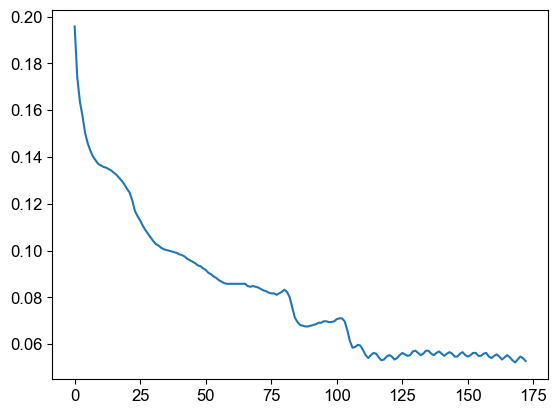

In [68]:
commercial = pd.read_json('D:\\hongbin\\20240328_PtRu_constant\\real_database.json')
plt.plot(commercial['reward'])
commercial['reward'].sum()


41.739423398

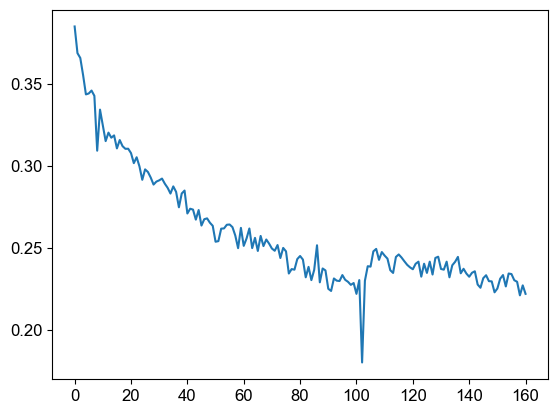

In [69]:
our_model = pd.read_json('D:\\hongbin\\20240321_our model\\real_database.json')
plt.plot(our_model['reward'])
our_model['reward'].sum()


35.04144421190001

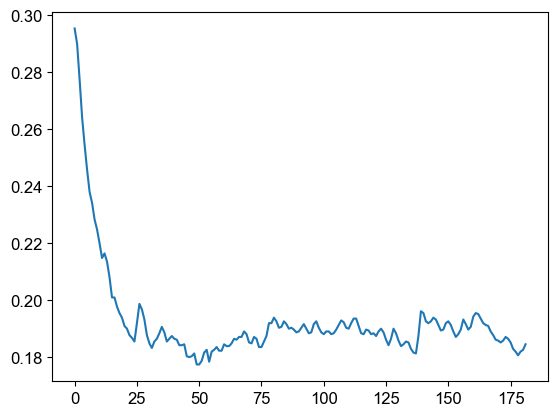

In [70]:
switch = pd.read_json('D:\\hongbin\\20240318_switch\\real_database.json')
plt.plot(switch['reward'])
switch['reward'].sum()


31.1248796275

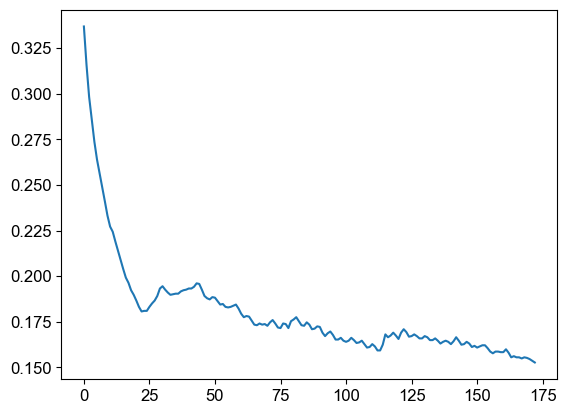

In [71]:
constant = pd.read_json('D:\\hongbin\\20240317_constant\\real_database.json')
plt.plot(constant['reward'])
constant['reward'].sum()


In [72]:
rl = pd.read_json('D:\\hongbin\\20240319_RL\\real_database.json')
CoPtRu_RL = pd.read_json('D:\\hongbin\\20240329_CoPtRu_RL\\real_database.json')

In [73]:


calc_time(commercial)
calc_time(constant)
calc_time(switch)
calc_time(our_model)
calc_time(rl)
calc_time(CoPtRu_RL)

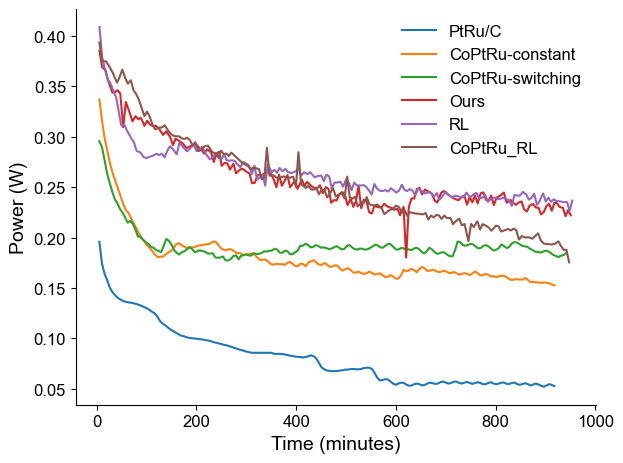

In [38]:
plt.rc('font', family='Arial', size=12)
fig, ax = plt.subplots()

ax.plot(commercial['time']/60, commercial['reward'], label='PtRu/C')
ax.plot(constant['time']/60, constant['reward'], label='CoPtRu-constant')
ax.plot(switch['time']/60, switch['reward'], label='CoPtRu-switching')
ax.plot(our_model['time']/60, our_model['reward'], label='Ours')
plot_df(rl, label='RL')
plot_df(CoPtRu_RL, label='CoPtRu_RL')
ax.legend()
ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Figure\\power_produced.png', dpi=300, transparent=True)

In [274]:
controlling = pd.read_json('D:\\hongbin\\20240323_control\\real_database.json')
calc_time(controlling)
model = model.eval()
prediction = []
for i, row in controlling.iterrows():
    prediction.append(model(torch.tensor([controlling['state'].iloc[i]]), torch.tensor([controlling['action'].iloc[i]])).item())
controlling['prediction'] = prediction


In [ ]:
['#3E4788', '#258A8D', '#55C667', '#FDE825']

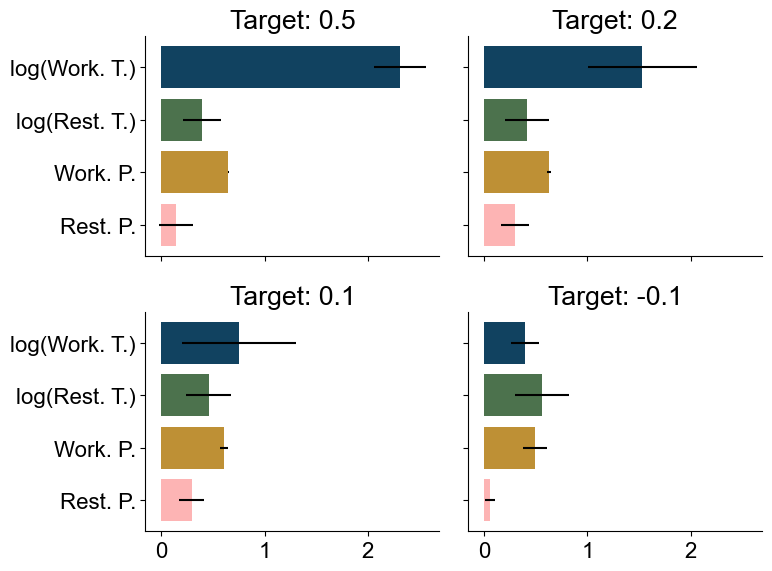

In [138]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True, figsize=(8,6))
xlabel = ['Resting potential','Working potential','log(Resting time)','log(Working time)']
xlabel = [
'Rest. P.',
'Work. P.',
'log(Rest. T.)','log(Work. T.)',
]
# color = ['#3F1173', '#952B80', '#E95362','#FEB37B']
color = ['#3E4788', '#258A8D', '#55C667', '#FDE825']
color = ['#440C53', '#3E4788', '#287D8E', '#28AF7F']
color = ['#FDB4B4', '#BE9035', '#4C724D', '#114260']
ax[0,0].barh(
    xlabel,
    np.array(controlling['action'].iloc[29:79].tolist()).mean(axis=0),
    xerr=np.array(controlling['action'].iloc[29:79].tolist()).std(axis=0),
    color=color
)
ax[0,0].set_title('Target: 0.5')
# ax[0,0].set_ylabel('Value')
ax[0,1].barh(
    xlabel,
    np.array(controlling['action'].iloc[79:129].tolist()).mean(axis=0),
    xerr=np.array(controlling['action'].iloc[79:129].tolist()).std(axis=0),
    color=color
)
ax[0,1].set_title('Target: 0.2')
ax[1,0].barh(
    xlabel,
    np.array(controlling['action'].iloc[129:179].tolist()).mean(axis=0),
    xerr=np.array(controlling['action'].iloc[129:179].tolist()).std(axis=0),
    color=color
)
ax[1,0].set_title('Target: 0.1')
# ax[1,0].set_ylabel('Value')
ax[1,1].barh(
    xlabel,
    np.array(controlling['action'].iloc[229:279].tolist()).mean(axis=0),
    xerr=np.array(controlling['action'].iloc[229:279].tolist()).std(axis=0),
    color=color
)
ax[1,1].set_title('Target: -0.1')
ax[1,0].tick_params(axis='x', rotation=0)
ax[1,1].tick_params(axis='x', rotation=0)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].invert_yaxis()
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].invert_yaxis()
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].invert_yaxis()
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].invert_yaxis()

plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\variables.png', dpi=300, transparent=True)

In [280]:
controlling[controlling['prediction'] <= 0.11]

,state,action,new_state,reward,done,order,time,prediction
129,"[[0.11973667140000001, 0.1197404936, 0.1197366...","[0.3761562109, 0.6390469074, 0.986559093000000...","[[0.1146524698, 0.11467920990000001, 0.1146410...",0.094715,False,"{'step_id': 'exp6_6', 'step_actual_time': (306...",46585.449063,0.099937
130,"[[0.1146524698, 0.11467920990000001, 0.1146410...","[0.1566348076, 0.6422455907, 0.3194041848, 0.8...","[[-0.1045639738, -0.10459452870000001, -0.1046...",0.098446,False,"{'step_id': 'exp6_7', 'step_actual_time': (306...",46892.217033,0.100015
131,"[[-0.1045639738, -0.10459452870000001, -0.1046...","[0.36795276400000004, 0.6323633194, 0.31000000...","[[0.1067072153, 0.1067301333, 0.1067988873, 0....",0.121501,False,"{'step_id': 'exp6_8', 'step_actual_time': (303...",47195.919183,0.099955
132,"[[0.1067072153, 0.1067301333, 0.1067988873, 0....","[0.36011248830000003, 0.6252512932000001, 0.35...","[[0.0987581387, 0.09874286500000001, 0.0987314...",0.120539,False,"{'step_id': 'exp6_9', 'step_actual_time': (301...",47497.066588,0.100075
133,"[[0.0987581387, 0.09874286500000001, 0.0987314...","[0.13440091910000002, 0.5489186049, 0.76116722...","[[-0.1275058836, -0.12756700810000002, -0.1275...",0.079112,False,"{'step_id': 'exp6_10', 'step_actual_time': (31...",47809.282150,0.099992
...,...,...,...,...,...,...,...,...
274,"[[-0.2415546626, -0.241493538, -0.2415432036, ...","[0.1261383891, 0.6187784672000001, 0.407774061...","[[-0.1355695575, -0.1355772018, -0.13561539350...",-0.086991,False,"{'step_id': 'exp12_18', 'step_actual_time': (3...",93576.780224,-0.100113
275,"[[-0.1355695575, -0.1355772018, -0.13561539350...","[0.0251310058, 0.6242699027, 0.9917434454, 0.5...","[[-0.2365086526, -0.23656977710000002, -0.2365...",-0.064197,False,"{'step_id': 'exp12_19', 'step_actual_time': (3...",93877.418164,-0.100030
276,"[[-0.2365086526, -0.23656977710000002, -0.2365...","[0.0206657518, 0.6212280393, 0.9681581259, 0.3...","[[-0.2405576855, -0.2405653298, -0.2405271232,...",-0.092477,False,"{'step_id': 'exp12_20', 'step_actual_time': (3...",94187.766964,-0.099998
277,"[[-0.2405576855, -0.2405653298, -0.2405271232,...","[0.0237092432, 0.3475727141, 0.4016323686, 0.3...","[[-0.2375705689, -0.2375285625, -0.2375400215,...",-0.101570,False,"{'step_id': 'exp12_21', 'step_actual_time': (3...",94491.006992,-0.099842


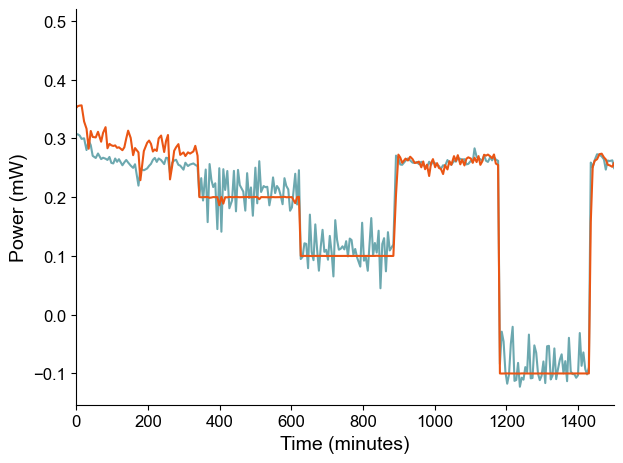

In [112]:
controlling = pd.read_json('D:\\hongbin\\20240323_control\\real_database.json')
calc_time(controlling)
model = model.eval()
prediction = []
for i, row in controlling.iterrows():
    prediction.append(model(torch.tensor([controlling['state'].iloc[i]]), torch.tensor([controlling['action'].iloc[i]])).item())
controlling['prediction'] = prediction

plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()

ax.plot(controlling['time']/60-150, controlling['reward'], label='Experimental result', color='#6CA8AF')

ax.plot(controlling['time']/60-150, controlling['prediction'], label='Model prediction', color='#EA5514')
# ax.legend()
# ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Power (mW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 1500)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_control.png', dpi=300, transparent=True)

In [56]:
print(switch['action'].iloc[-1])
print(our_model['action'].iloc[-1])

[0.02, 0.65, 0.31, 1.778]
[0.400000006, 0.6499999762, 0.31000000240000003, 1.5320365429]


55060.62418534068

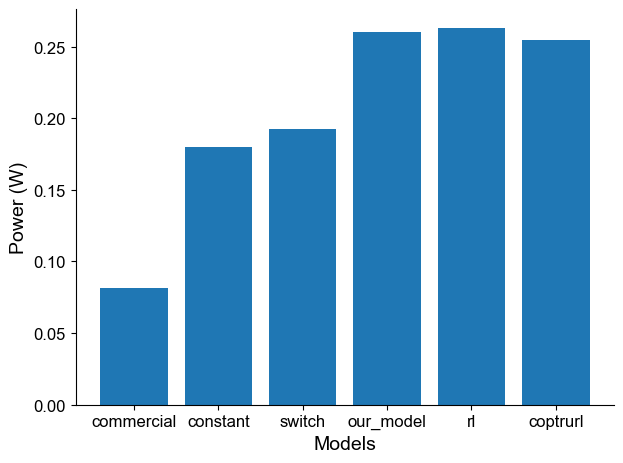

In [78]:
rewards = [
    calc_reward(commercial)/commercial['time'].iloc[-1],
    calc_reward(constant)/constant['time'].iloc[-1],
    calc_reward(switch)/switch['time'].iloc[-1],
    calc_reward(our_model)/our_model['time'].iloc[-1],
    calc_reward(rl)/rl['time'].iloc[-1],
    calc_reward(CoPtRu_RL)/CoPtRu_RL['time'].iloc[-1],
]
labels = ['commercial', 'constant', 'switch', 'our_model', 'rl', 'coptrurl']
plt.bar(labels, rewards)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('power_produced_bar.png', dpi=300, transparent=True)

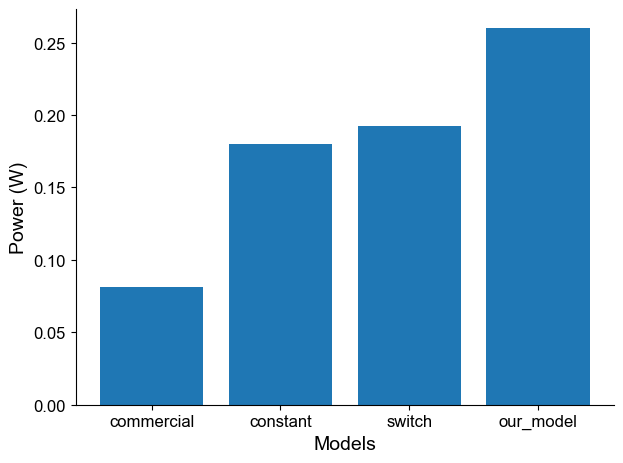

In [79]:
rewards = [
    calc_reward(commercial)/commercial['time'].iloc[-1],
    calc_reward(constant)/constant['time'].iloc[-1],
    calc_reward(switch)/switch['time'].iloc[-1],
    calc_reward(our_model)/our_model['time'].iloc[-1],

]
labels = ['commercial', 'constant', 'switch', 'our_model']
plt.bar(labels, rewards)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('power_produced_bar.png', dpi=300, transparent=True)

In [44]:
commercial['time']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
168    0.0
169    0.0
170    0.0
171    0.0
172    0.0
Name: time, Length: 173, dtype: float64

In [54]:
170/700


0.24285714285714285

In [58]:
300/60

5.0

# Comparison between constant strategy and our model

In [112]:
constant = pd.read_json('D:\\hongbin\\20240401_CoPtRu_constant\\real_database.json')
our_model = pd.read_json('D:\\hongbin\\20240321_our model\\real_database.json')
switch = pd.read_json('D:\\hongbin\\20240402_CoPtRu_switch\\real_database.json')

In [114]:
calc_time(constant)
calc_time(switch)
calc_time(our_model)

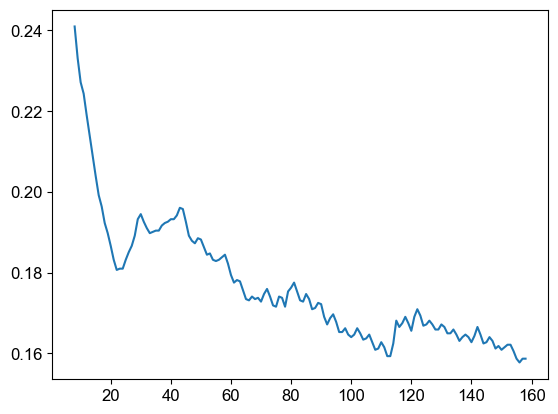

In [89]:
plt.plot(constant['reward'][(constant['time']/60-47.7 <= 800) * (constant['time']/60-47.7>=0)])

In [184]:


print("Constant: ", calc_reward_condition(constant, 0.3, 800*60))
print("Ours: ", calc_reward_condition(our_model, 0.3, 800*60))
print(calc_reward_condition(constant, 0.4, 800*60))
print(calc_reward_condition(switch, 0.4, 800*60))
print(calc_reward_condition(our_model, 0.4, 800*60))

15.0
Constant:  0.13795035460992905
Ours:  0.2216265891514919
0.14626530612244895
0.17378260869565224
0.23226993208206415


In [111]:
print("Improvment: ", (calc_reward_condition(our_model, 0.3, 800*60)-calc_reward_condition(constant, 0.3, 800*60))/calc_reward_condition(constant, 0.3, 800*60))
print("Improvment: ", (calc_reward_condition(our_model, 0.4, 800*60)-calc_reward_condition(constant, 0.4, 800*60))/calc_reward_condition(constant, 0.4, 800*60))

Improvment:  0.09563806645224594
Improvment:  0.13703562295109079


offset_constant 954.8085118845224
offset_ours 326.22776601683796


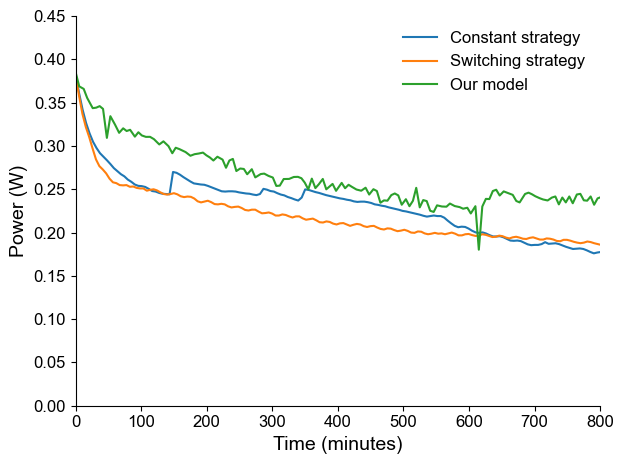

In [118]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
print("offset_constant", find_offset(constant, 0.4))
print("offset_ours", find_offset(our_model, 0.4))
ax.plot((constant['time']-find_offset(constant, 0.4))/60, constant['reward'], label='Constant strategy')
ax.plot((switch['time']-find_offset(switch, 0.4))/60, switch['reward'], label='Switching strategy')
ax.plot((our_model['time']-find_offset(our_model, 0.4))/60, our_model['reward'], label='Our model')
ax.legend()
ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 0.45)
plt.xlim(0, 800)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel.png', dpi=300, transparent=True)

# Comparison: 24-04-04

In [409]:


constant = pd.read_csv('D:\\hongbin\\20240404_constant\\exp0_1_2024-04-04_15-40-13_C01.csv', sep=';')
switch = pd.read_csv('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv', sep=';')

energy_constant = get_total_energy(constant, ref_potential, counter_potential)
reward_constant = energy_constant / constant['time/s'].max()
print("Constant:", reward_constant)

energy_switch = get_total_energy(switch, ref_potential, counter_potential)
reward_switch = energy_switch / switch['time/s'].max()
print("Switch:", reward_switch)


Constant: 0.22912925170068027
Switch: 0.277461964614316


In [203]:
constant = csv2json('D:\\hongbin\\20240404_constant\\exp0_1_2024-04-04_15-40-13_C01.csv')
switch = csv2json('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv')
our_model = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')

In [204]:
calc_time(constant)
calc_time(switch)
calc_time(our_model)

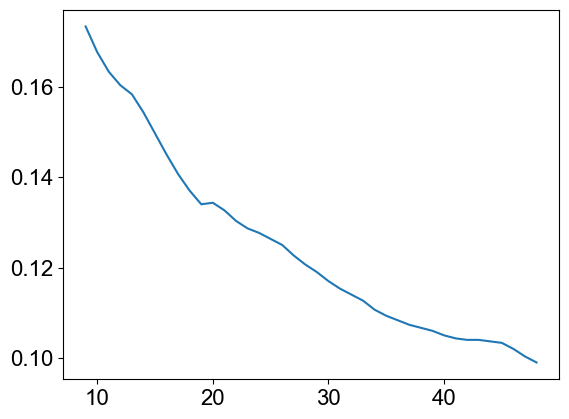

In [189]:
plt.plot(constant['reward'][(constant['time']/60-47.7 <= 800) * (constant['time']/60-47.7>=0)])

In [161]:

print("Constant: ", calc_reward_condition(constant, 0.3, 800*60))
print("Ours: ", calc_reward_condition(our_model, 0.3, 800*60))
print(calc_reward_condition(constant, 0.4, 800*60))
print(calc_reward_condition(switch, 0.4, 800*60))
print(calc_reward_condition(our_model, 0.4, 800*60))

Constant:  0.13795035460992905
Ours:  0.2216265891514919
0.14626530612244895
0.17378260869565224
0.23226993208206415


In [162]:
print("Improvment: ", (calc_reward_condition(our_model, 0.3, 800*60)-calc_reward_condition(constant, 0.3, 800*60))/calc_reward_condition(constant, 0.3, 800*60))
print("Improvment: ", (calc_reward_condition(our_model, 0.4, 800*60)-calc_reward_condition(constant, 0.4, 800*60))/calc_reward_condition(constant, 0.4, 800*60))

Improvment:  0.6065677379240328
Improvment:  0.588004279617852


offset_constant 300.0
offset_ours 1477.484268228578


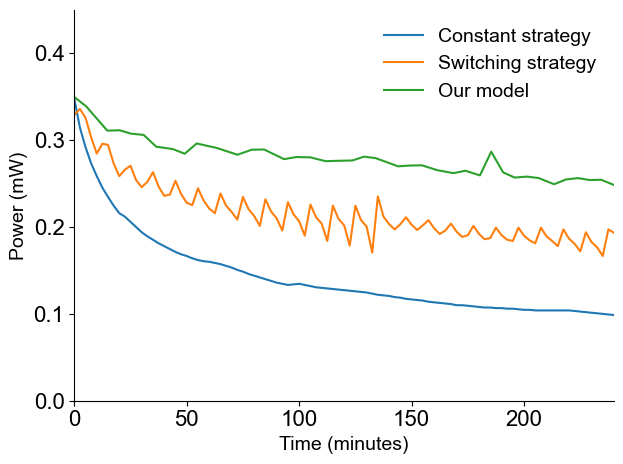

In [214]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
print("offset_constant", find_offset(constant, 0.35))
print("offset_ours", find_offset(our_model, 0.35))
ax.plot((constant['time']-find_offset(constant, 0.35))/60, constant['reward'], label='Constant strategy')
ax.plot((switch['time']-find_offset(switch, 0.35))/60, switch['reward'], label='Switching strategy')
ax.plot((our_model['time']-find_offset(our_model, 0.35))/60, our_model['reward'], label='Our model')
ax.legend()
ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Power (mW)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 0.45)
plt.xlim(0, 240)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel.png', dpi=300, transparent=True)

In [174]:
constant_bar = constant[constant['time']-find_offset(constant, 0.35)<60*240]['reward'].mean()
switch_bar = switch[switch['time']-find_offset(switch, 0.35)<60*240]['reward'].mean()
our_model_bar = our_model[our_model['time']-find_offset(our_model, 0.35)<60*240]['reward'].mean()


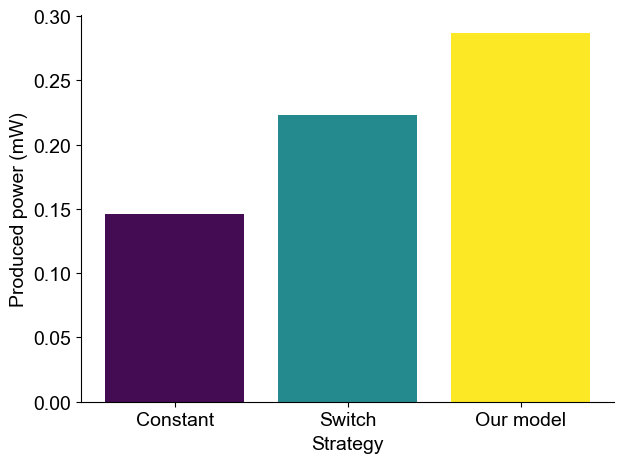

In [213]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(['Constant', 'Switch', 'Our model'], [constant_bar, switch_bar, our_model_bar], color=['#440C53', '#258A8D', '#FDE825'])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot.png', dpi=300, transparent=True)

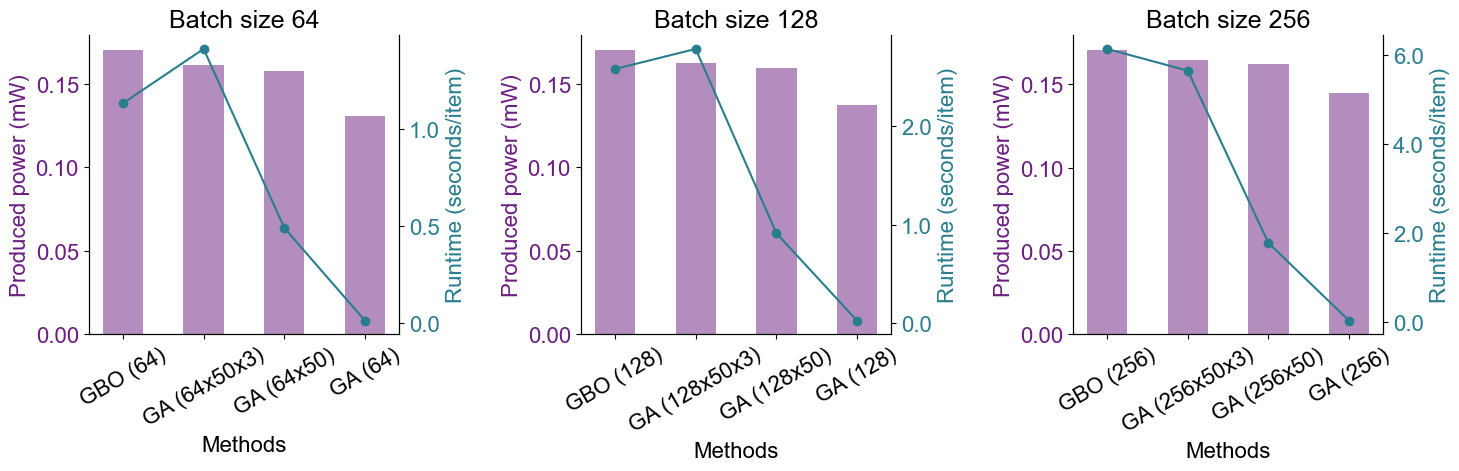

In [137]:
plt.rc('font', family='Arial', size=16)

# Data separated by Batch size (64, 128, 256)
methods_64 = ['GBO (64)', 'GA (64x50x3)', 'GA (64x50)', 'GA (64)']
performance_64 = [0.17063446319351594, 0.16126663255194823, 0.15777957667596637, 0.1307496923021972]
runtime_64 = [339.3663, 423.3539, 146.6912, 3.4853]
runtime_64 = [x/300 for x in runtime_64]

methods_128 = ['GBO (128)', 'GA (128x50x3)', 'GA (128x50)', 'GA (128)']
performance_128 = [0.17070084089413284, 0.16279618078221877, 0.15988260994975764, 0.13739822543536623]
runtime_128 = [775.5008, 836.9274, 273.5164, 6.1419]
runtime_128 = [x/300 for x in runtime_128]

methods_256 = ['GBO (256)', 'GA (256x50x3)', 'GA (256x50)', 'GA (256)']
performance_256 = [0.17075893816227714, 0.16438096017887194, 0.16212080111106236, 0.14456234756546715]
runtime_256 = [1844.3721, 1697.9127, 535.6597, 11.5045]
runtime_256 = [x/300 for x in runtime_256]

# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

barcolor = '#6B1C81'
linecolor = '#287D8E'
# Plot for Batch size 64
axs[0].bar(methods_64, performance_64, color=barcolor, width = 0.5, alpha=0.5)
axs[0].set_title('Batch size 64', fontsize=18)
axs[0].set_xlabel('Methods')
axs[0].set_ylabel('Produced power (mW)', color=barcolor)
axs[0].tick_params(axis='y', labelcolor=barcolor)
axs[0].tick_params(axis='x', rotation=30)
axs[0].spines['top'].set_visible(False)
# axs[0].spines['right'].set_visible(False)
axs2 = axs[0].twinx()
axs2.plot(methods_64, runtime_64, color=linecolor, marker='o')
axs2.set_ylabel('Runtime (seconds/item)', color=linecolor)
axs2.tick_params(axis='y', labelcolor=linecolor)
axs2.spines['top'].set_visible(False)

# Plot for Batch size 128
axs[1].bar(methods_128, performance_128, color=barcolor, width = 0.5, alpha=0.5)
axs[1].set_title('Batch size 128', fontsize=18)
axs[1].set_xlabel('Methods')
axs[1].set_ylabel('Produced power (mW)', color=barcolor)
axs[1].tick_params(axis='y', labelcolor=barcolor)
axs[1].tick_params(axis='x', rotation=30)
axs[1].spines['top'].set_visible(False)
# axs[1].spines['right'].set_visible(False)
axs2 = axs[1].twinx()
axs2.plot(methods_128, runtime_128, color=linecolor, marker='o')
axs2.set_ylabel('Runtime (seconds/item)', color=linecolor)
axs2.tick_params(axis='y', labelcolor=linecolor)
axs2.spines['top'].set_visible(False)

plt.sca(axs2)
plt.yticks(range(3), ['0.0', '1.0', '2.0'], color=linecolor)



# Plot for Batch size 256
axs[2].bar(methods_256, performance_256, color=barcolor, width = 0.5, alpha=0.5)
axs[2].set_title('Batch size 256', fontsize=18)
axs[2].set_xlabel('Methods')
axs[2].set_ylabel('Produced power (mW)', color=barcolor)
axs[2].tick_params(axis='y', labelcolor=barcolor)
axs[2].tick_params(axis='x', rotation=30)
axs[2].spines['top'].set_visible(False)
# axs[2].spines['right'].set_visible(False)
axs2 = axs[2].twinx()
axs2.plot(methods_256, runtime_256, color=linecolor, marker='o')
axs2.set_ylabel('Runtime (seconds/item)', color=linecolor)
axs2.tick_params(axis='y', labelcolor=linecolor)
axs2.spines['top'].set_visible(False)

plt.sca(axs2)
plt.yticks([0,2,4,6], ['0.0', '2.0', '4.0', '6.0'], color=linecolor)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\justification.png', dpi=300, transparent=True)


# 24-04-11 figures

In [4]:
PtRu_0408 = csv2json('D:\\hongbin\\20240408_PtRu\\exp0_1_2024-04-08_14-17-10_C01.csv')
PtRu_0408_12h = csv2json('D:\\hongbin\\20240408_PtRu_12hours\\exp0_1_2024-04-08_20-44-13_C01.csv')
PtRu_0409 = csv2json('D:\\hongbin\\20240409_PtRu\\exp0_1_2024-04-09_11-41-20_C01.csv')
PtRu_0409_2 = csv2json('D:\\hongbin\\20240409_PtRu_2\\exp0_1_2024-04-09_16-08-28_C01.csv')
CoPtRu_0409_12h = csv2json('D:\\hongbin\\20240409_CoPtRu_constant_12hours\\exp0_1_2024-04-08_20-36-53_C01.csv')
CoPtRu_const = csv2json('D:\\hongbin\\20240410_CoPtRu_constant_2\\exp0_1_2024-04-10_12-02-03_C01.csv')
CoPtRu_switch = csv2json('D:\\hongbin\\20240410_CoPtRu_switch_2\\exp0_1_2024-04-10_16-30-08_C01.csv')
CoPtRu_RL = pd.read_json('D:\\hongbin\\20240410_CoPtRu_RL_2\\real_database.json')
CoPtRu_switch_3 = csv2json('D:\\hongbin\\20240411_CoPtRu_switch_3\\exp0_1_2024-04-11_12-51-41_C01.csv')
CoPtRu_switch_4 = csv2json('D:\\hongbin\\20240411_CoPtRu_switch_4\\exp0_1_2024-04-11_17-36-43_C01.csv')
CoPtRu_RL_3 = pd.read_json('D:\\hongbin\\20240411_CoPtRu_RL_3\\real_database.json')
CoPtRu_const_3 = csv2json('D:\\hongbin\\20240412_CoPtRu_constant_3\\exp0_1_2024-04-12_14-11-25_C01.csv')
# merge
constant = csv2json('D:\\hongbin\\20240404_constant\\exp0_1_2024-04-04_15-40-13_C01.csv')
switch = csv2json('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv')
our_model = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')

In [5]:
calc_time(PtRu_0408)
calc_time(PtRu_0408_12h)
calc_time(PtRu_0409)
calc_time(PtRu_0409_2)
calc_time(CoPtRu_0409_12h)
calc_time(CoPtRu_const)
calc_time(CoPtRu_switch)
calc_time(CoPtRu_RL)
calc_time(constant)
calc_time(switch)
calc_time(our_model)
calc_time(CoPtRu_switch_3)
calc_time(CoPtRu_switch_4)
calc_time(CoPtRu_RL_3)
calc_time(CoPtRu_const_3)

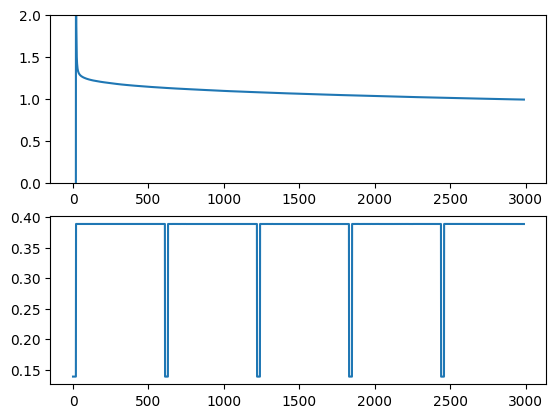

In [24]:
i=34
fig, ax = plt.subplots(2,1)
ax[0].plot(our_model['state'].iloc[i][1])
ax[0].set_ylim(0,2)
ax[1].plot(our_model['state'].iloc[i+1][0])

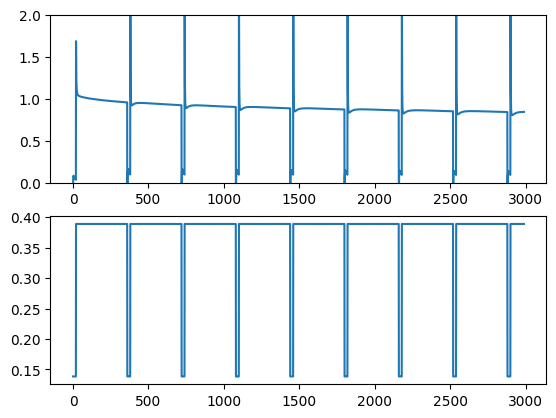

In [33]:
i=81
fig, ax = plt.subplots(2,1)
ax[0].plot(our_model['state'].iloc[i][1])
ax[0].set_ylim(0,2)
ax[1].plot(our_model['state'].iloc[i+1][0])

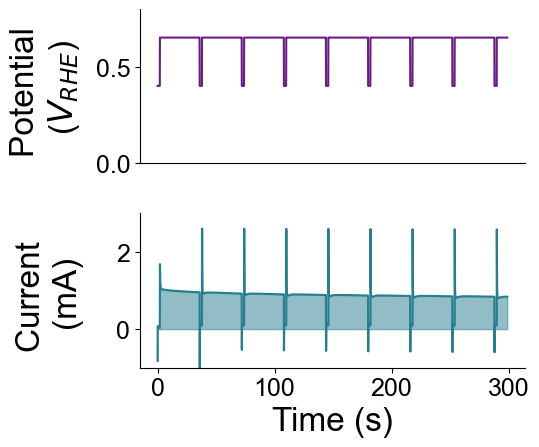

In [64]:
i = 81
# Set font as Arial and size as 20
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rc('xtick', labelsize=18)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=18)  # y축 눈금 폰트 크기
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
# ax[0].set_title('State')
ax[0].set_ylabel('Potential \n'+r'($V_{RHE}$)')
ax[0].yaxis.set_label_coords(-0.1, 0.5)
ax[0].plot(np.arange(2990)/10, np.array(our_model['state'].iloc[i])[0]+0.263, color='#6B1C81')
ax[0].set_xticks([])
ax[0].set_ylim([0.0, 0.8])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Current \n(mA)')
ax[1].yaxis.set_label_coords(-0.1, 0.5)
ax[1].plot(np.arange(2990)/10, np.array(our_model['state'].iloc[i])[1], color='#287D8E')
ax[1].fill_between(np.arange(2990)/10, np.array(our_model['state'].iloc[i])[1], alpha=0.5, color='#287D8E')
ax[1].set_ylim([-1, 3])
# remove top and right spines
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].yaxis.set_label_coords(-0.15, 0.5)
ax[1].yaxis.set_label_coords(-0.15, 0.5)

# Set figure title
# fig.suptitle('Switching')
# Share x-axis
fig.align_xlabels()
fig.tight_layout()
# Save figure
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\Action_for_explanation_small_1.png', dpi=300, transparent=True)

(0.0, 2.0)

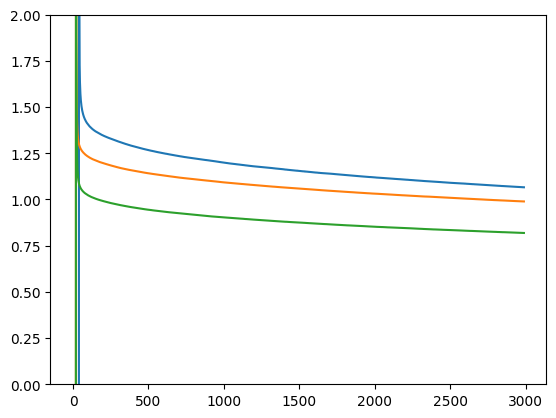

In [30]:
plt.plot(our_model['state'].iloc[12][1])
plt.plot(our_model['state'].iloc[34][1])
plt.plot(our_model['state'].iloc[80][1])
plt.ylim(0,2)

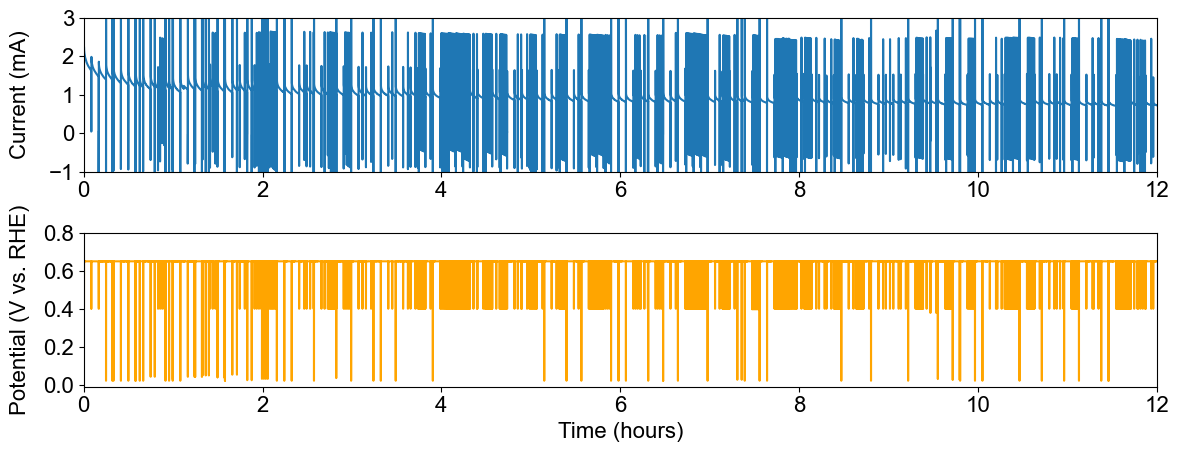

In [389]:
# .plot(np.array(our_model['state'].iloc[0][0])-ref_potential)
# our_model['state'].iloc[0][1]

curr = []
for i, row in our_model.iterrows():
   curr.append(row['state'][1])
curr = np.hstack(curr)
pot = []
for i, row in our_model.iterrows():
   pot.append(row['state'][0])
pot = np.hstack(pot)

fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(np.arange(len(curr))/10/3600, curr)
ax[0].set_ylim(-1, 3)
ax[0].set_yticks([-1,0,1,2,3])
ax[0].set_xlim(0, 12)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)
# axs2 = ax.twinx()
ax[1].plot(np.arange(len(curr))/10/3600, pot-ref_potential, color='orange')
ax[1].set_xlim(0, 12)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].set_xlabel('Time (hours)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\our_model_curr_vs_pot_12h.png', dpi=300, transparent=True)

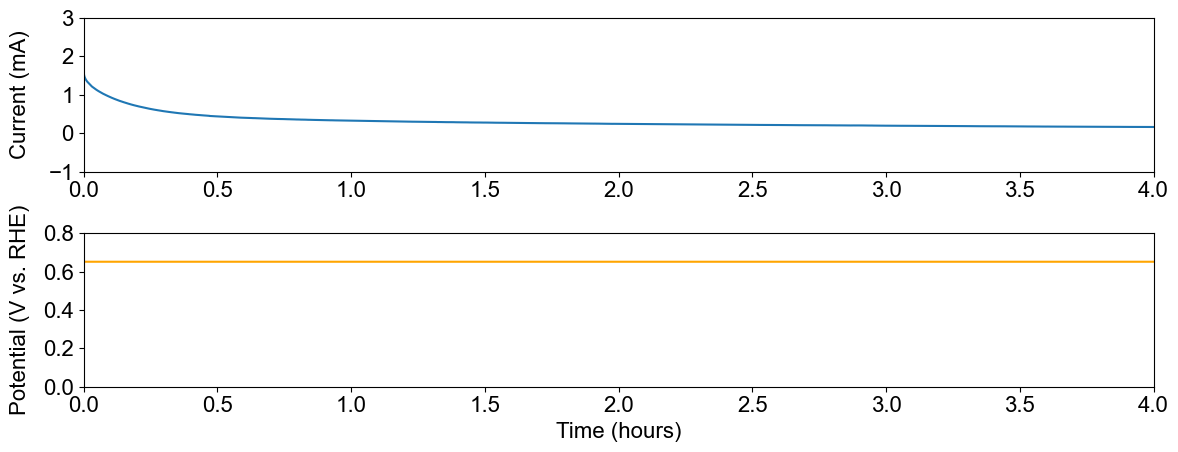

In [385]:
df = pd.read_csv('D:\\hongbin\\20240409_PtRu\\exp0_1_2024-04-09_11-41-20_C01.csv', sep=';')
df['Ewe/V']

fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(df['time/s']/3600, df['I/mA'])
ax[0].set_ylim(0, 2)
ax[0].set_yticks([-1,0,1,2,3])
ax[0].set_xlim(0, 4)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)

ax[1].plot(df['time/s']/3600, df['Ewe/V']-ref_potential, color='orange')
ax[1].set_xlim(0, 4)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
ax[1].set_xlabel('Time (hours)')
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\PtRu_curr_vs_pot_4h.png', dpi=300, transparent=True)

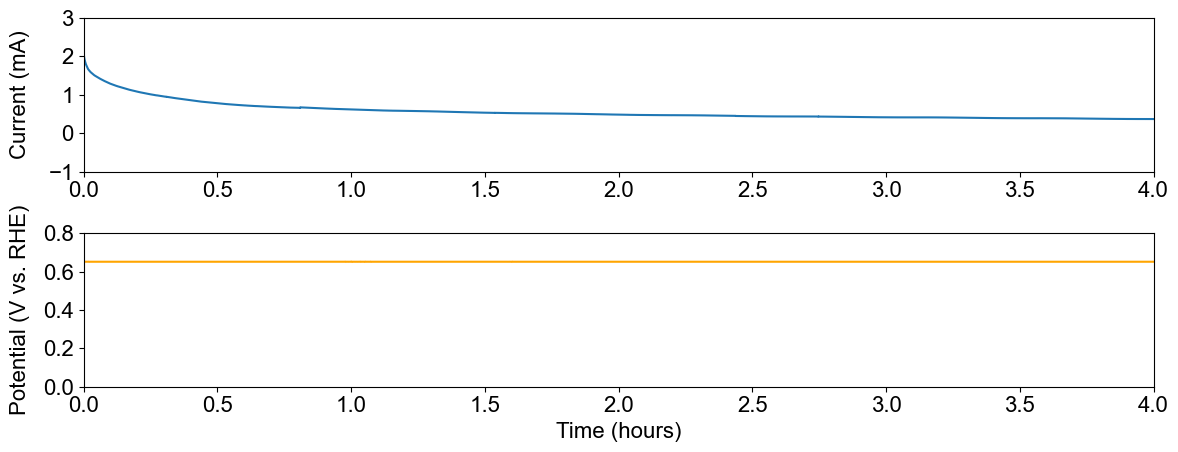

In [384]:
df = pd.read_csv('D:\\hongbin\\20240412_CoPtRu_constant_3\\exp0_1_2024-04-12_14-11-25_C01.csv', sep=';')

fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(df['time/s']/3600, df['I/mA'])
ax[0].set_ylim(0, 2)
ax[0].set_yticks([-1,0,1,2,3])
ax[0].set_xlim(0, 4)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)
ax[1].plot(df['time/s']/3600, df['Ewe/V']-ref_potential, color='orange')
ax[1].set_xlim(0, 4)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
ax[1].set_xlabel('Time (hours)')
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\CoPtRu_curr_vs_pot_4h.png', dpi=300, transparent=True)

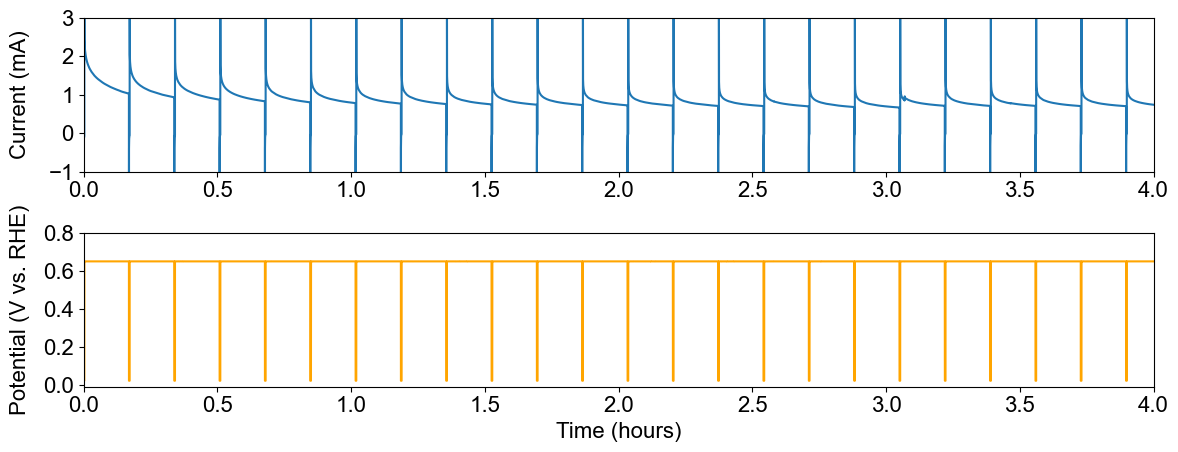

In [382]:
df = pd.read_csv('D:\\hongbin\\20240411_CoPtRu_switch_3\\exp0_1_2024-04-11_12-51-41_C01.csv', sep=';')

fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(df['time/s']/3600, df['I/mA'])
ax[0].set_ylim(-1, 3)
ax[0].set_yticks([-1,0,1,2,3])
ax[0].set_xlim(0, 4)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)
ax[1].plot(df['time/s']/3600, df['Ewe/V']-ref_potential, color='orange')
ax[1].set_xlim(0, 4)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
ax[1].set_xlabel('Time (hours)')
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\CoPtRu_swi_curr_vs_pot_4h.png', dpi=300, transparent=True)

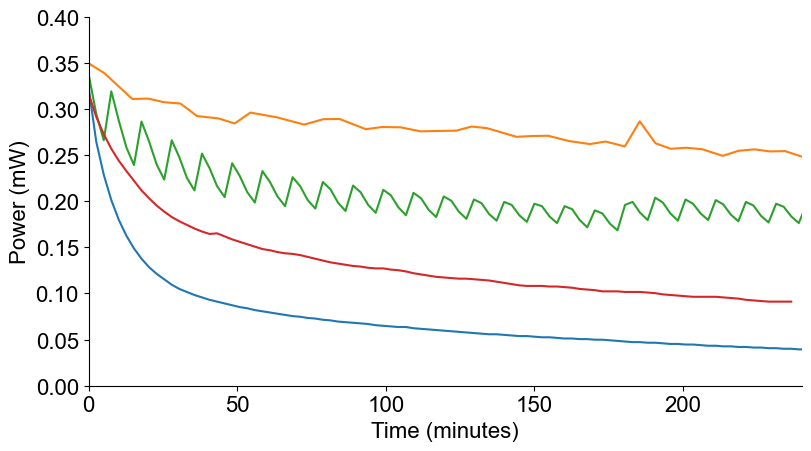

In [253]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(8.4,4.8))
# ax.plot((PtRu_0408['time']-find_offset(PtRu_0408, 0.35))/60, PtRu_0408['reward'], label='PtRu_0408 strategy')
# ax.plot((PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35))/60, PtRu_0408_12h['reward'], label='PtRu_0408_12h strategy')
ax.plot((PtRu_0409['time']-find_offset(PtRu_0409, 0.35))/60, PtRu_0409['reward'], label='PtRu_0409 strategy')
# ax.plot((PtRu_0409_2['time']-find_offset(PtRu_0409_2, 0.35))/60, PtRu_0409_2['reward'], label='PtRu_0409_2 strategy')
# ax.plot((CoPtRu_0409_12h['time']-find_offset(CoPtRu_0409_12h, 0.35))/60, CoPtRu_0409_12h['reward'], label='CoPtRu_0409_12h strategy')
# ax.plot((CoPtRu_const['time']-find_offset(CoPtRu_const, 0.35))/60, CoPtRu_const['reward'], label='CoPtRu_const strategy')
# ax.plot((CoPtRu_switch['time']-find_offset(CoPtRu_switch, 0.35))/60, CoPtRu_switch['reward'], label='CoPtRu_switch strategy')
# ax.plot((CoPtRu_RL['time']-find_offset(CoPtRu_RL, 0.35))/60, CoPtRu_RL['reward'], label='CoPtRu_RL strategy')
# ax.plot((constant['time']-find_offset(constant, 0.35))/60, constant['reward'], label='Constant strategy')
# ax.plot((switch['time']-find_offset(switch, 0.35))/60, switch['reward'], label='Switching strategy')
ax.plot((our_model['time']-find_offset(our_model, 0.35))/60, our_model['reward'], label='Our model')
ax.plot((CoPtRu_switch_3['time']-find_offset(CoPtRu_switch_3, 0.35))/60, CoPtRu_switch_3['reward'], label='CoPtRu_switch_3')
# ax.plot((CoPtRu_switch_4['time']-find_offset(CoPtRu_switch_4, 0.35))/60, CoPtRu_switch_4['reward'], label='CoPtRu_switch_4')
# ax.plot((CoPtRu_RL_3['time']-find_offset(CoPtRu_RL_3, 0.35))/60, CoPtRu_RL_3['reward'], label='CoPtRu_RL_3')
ax.plot((CoPtRu_const_3['time']-find_offset(CoPtRu_const_3, 0.35))/60, CoPtRu_const_3['reward'], label='CoPtRu_const_3 strategy')

# ax.legend(fontsize=12, ncol=2)
# # ax.legend(fontsize=12, bbox_to_anchor=(1,1))
# ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Power (mW)', fontsize=16)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 0.4)
plt.xlim(0, 240)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel_commercial.png', dpi=300, transparent=True)

In [104]:
time = PtRu_0408['time']-find_offset(PtRu_0408, 0.35)
PtRu_0408_bar = PtRu_0408[(time<60*240)&(time>0)]['reward'].mean()
time = PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35)
PtRu_0408_12h_bar = PtRu_0408_12h[(time<60*240)&(time>0)]['reward'].mean()
time = PtRu_0409['time']-find_offset(PtRu_0409, 0.35)
PtRu_0409_bar = PtRu_0409[(time<60*240)&(time>0)]['reward'].mean()
time = PtRu_0409_2['time']-find_offset(PtRu_0409_2, 0.35)
PtRu_0409_2_bar = PtRu_0409_2[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_0409_12h['time']-find_offset(CoPtRu_0409_12h, 0.35)
CoPtRu_0409_12h_bar = CoPtRu_0409_12h[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_const['time']-find_offset(CoPtRu_const, 0.35)
CoPtRu_const_bar = CoPtRu_const[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_const['time']-find_offset(CoPtRu_const, 0.35)
CoPtRu_const_bar = CoPtRu_const[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_switch['time']-find_offset(CoPtRu_switch, 0.35)
CoPtRu_switch_bar = CoPtRu_switch[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_RL['time']-find_offset(CoPtRu_RL, 0.35)
CoPtRu_RL_bar = CoPtRu_RL[(time<60*240)&(time>0)]['reward'].mean()
time = constant['time']-find_offset(constant, 0.35)
constant_bar = constant[(time<60*240)&(time>0)]['reward'].mean()
time = switch['time']-find_offset(switch, 0.35)
switch_bar = switch[(time<60*240)&(time>0)]['reward'].mean()
time = our_model['time']-find_offset(our_model, 0.35)
our_model_bar = our_model[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_switch_3['time']-find_offset(CoPtRu_switch_3, 0.35)
CoPtRu_switch_3_bar = CoPtRu_switch_3[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_switch_4['time']-find_offset(CoPtRu_switch_4, 0.35)
CoPtRu_switch_4_bar = CoPtRu_switch_4[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_RL_3['time']-find_offset(CoPtRu_RL_3, 0.35)
CoPtRu_RL_3_bar = CoPtRu_RL_3[(time<60*240)&(time>0)]['reward'].mean()
time = CoPtRu_const_3['time']-find_offset(CoPtRu_const_3, 0.35)
CoPtRu_const_3_bar = CoPtRu_const_3[(time<60*240)&(time>0)]['reward'].mean()

In [105]:
[PtRu_0408_bar, PtRu_0409_bar, PtRu_0409_2_bar, CoPtRu_0409_12h_bar, constant_bar,CoPtRu_const_3_bar,  switch_bar,  CoPtRu_switch_3_bar, CoPtRu_switch_4_bar, CoPtRu_RL_bar, our_model_bar,CoPtRu_RL_3_bar],

print(PtRu_0408_bar)
# print(PtRu_0408_12h_bar)
print(PtRu_0409_bar)
print(PtRu_0409_2_bar)
print(CoPtRu_0409_12h_bar)
print(constant_bar)
print(CoPtRu_const_3_bar)
print(switch_bar)
print(CoPtRu_switch_3_bar)
print(CoPtRu_switch_4_bar)
# print(CoPtRu_const_bar)
# print(CoPtRu_switch_bar)
print(CoPtRu_RL_bar)
print(our_model_bar)
print(CoPtRu_RL_3_bar)

0.036470177886292296
0.07238228113010114
0.07453086850366236
0.12345308685036624
0.14147192186955007
0.1324378635642517
0.2158562957795605
0.2063969305894664
0.17239623299616325
0.3000357386829268
0.2782698775026316
0.2742677378414634


In [ ]:
PtRu_0408_bar = PtRu_0408[PtRu_0408['time']-find_offset(PtRu_0408, 0.35)<60*240]['reward'].mean()
PtRu_0408_12h_bar = PtRu_0408_12h[PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35)<60*240]['reward'].mean()
PtRu_0409_bar = PtRu_0409[PtRu_0409['time']-find_offset(PtRu_0409, 0.35)<60*240]['reward'].mean()
PtRu_0409_2_bar = PtRu_0409_2[PtRu_0409_2['time']-find_offset(PtRu_0409_2, 0.35)<60*240]['reward'].mean()
CoPtRu_0409_12h_bar = CoPtRu_0409_12h[CoPtRu_0409_12h['time']-find_offset(CoPtRu_0409_12h, 0.35)<60*240]['reward'].mean()
CoPtRu_const_bar = CoPtRu_const[CoPtRu_const['time']-find_offset(CoPtRu_const, 0.35)<60*240]['reward'].mean()
CoPtRu_switch_bar = CoPtRu_switch[CoPtRu_switch['time']-find_offset(CoPtRu_switch, 0.35)<60*240]['reward'].mean()
CoPtRu_RL_bar = CoPtRu_RL[CoPtRu_RL['time']-find_offset(CoPtRu_RL, 0.35)<60*240]['reward'].mean()
constant_bar = constant[constant['time']-find_offset(constant, 0.35)<60*240]['reward'].mean()
switch_bar = switch[switch['time']-find_offset(switch, 0.35)<60*240]['reward'].mean()
our_model_bar = our_model[our_model['time']-find_offset(our_model, 0.35)<60*240]['reward'].mean()
CoPtRu_switch_3_bar = CoPtRu_switch_3[CoPtRu_switch_3['time']-find_offset(CoPtRu_switch_3, 0.35)<60*240]['reward'].mean()
CoPtRu_switch_4_bar = CoPtRu_switch_4[CoPtRu_switch_4['time']-find_offset(CoPtRu_switch_4, 0.35)<60*240]['reward'].mean()
CoPtRu_RL_3_bar = CoPtRu_RL_3[CoPtRu_RL_3['time']-find_offset(CoPtRu_RL_3, 0.35)<60*240]['reward'].mean()
CoPtRu_const_3_bar = CoPtRu_const_3[CoPtRu_const_3['time']-find_offset(CoPtRu_const_3, 0.35)<60*240]['reward'].mean()

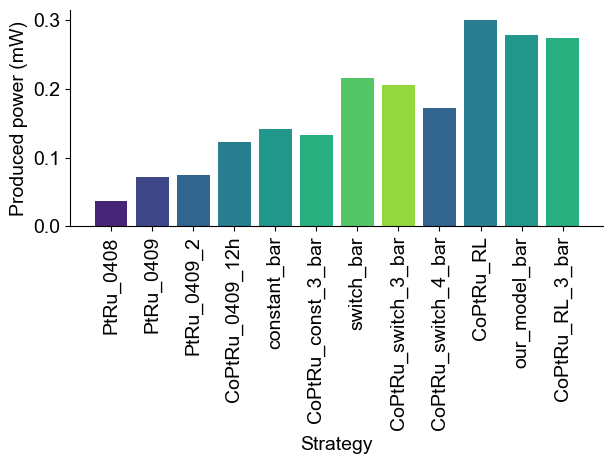

In [106]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(
    ['PtRu_0408', 'PtRu_0409', 'PtRu_0409_2', 'CoPtRu_0409_12h', 'constant_bar','CoPtRu_const_3_bar',
     'switch_bar','CoPtRu_switch_3_bar', 'CoPtRu_switch_4_bar', 'CoPtRu_RL', 'our_model_bar', 'CoPtRu_RL_3_bar'],
    [PtRu_0408_bar, PtRu_0409_bar, PtRu_0409_2_bar, CoPtRu_0409_12h_bar, constant_bar,CoPtRu_const_3_bar,  switch_bar,  CoPtRu_switch_3_bar, CoPtRu_switch_4_bar, CoPtRu_RL_bar, our_model_bar,CoPtRu_RL_3_bar],
    color=[ '#482677', '#3E4788',  '#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840','#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840', '#94D840'])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
[ '#482677', '#3E4788',  '#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840']

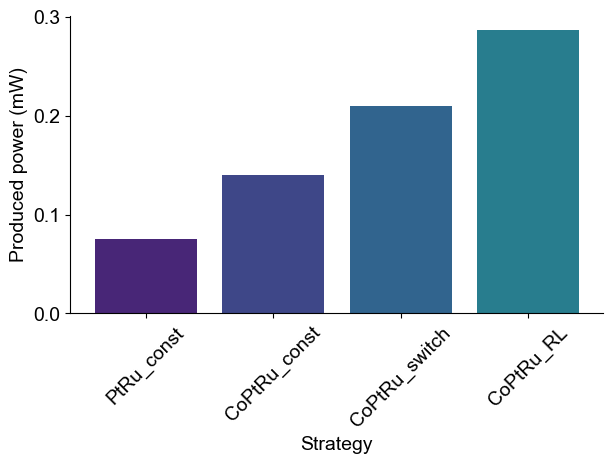

In [345]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(
    ['PtRu_const', 'CoPtRu_const', 'CoPtRu_switch','CoPtRu_RL',],
    [PtRu_0409_bar, CoPtRu_const_3_bar, CoPtRu_switch_3_bar, our_model_bar,],
    color=[ '#482677', '#3E4788',  '#31648E',  '#287D8E', ])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_commercial.png', dpi=300, transparent=True)

In [354]:
(pd.read_csv('D:\\hongbin\\20240410_CoPtRu_RL_2\\exp4_13_2024-04-11_09-11-34_C01.csv', sep=';')[['Ewe/V', 'I/mA']].iloc[0:2990].to_numpy()/np.array([1,50])).T

array([[-0.24164736, -0.24160917, -0.24162826, ...,  0.38841131,
         0.38835019,  0.38834637],
       [-0.03410661, -0.02848244, -0.02032795, ...,  0.01918471,
         0.0191868 ,  0.01917765]])

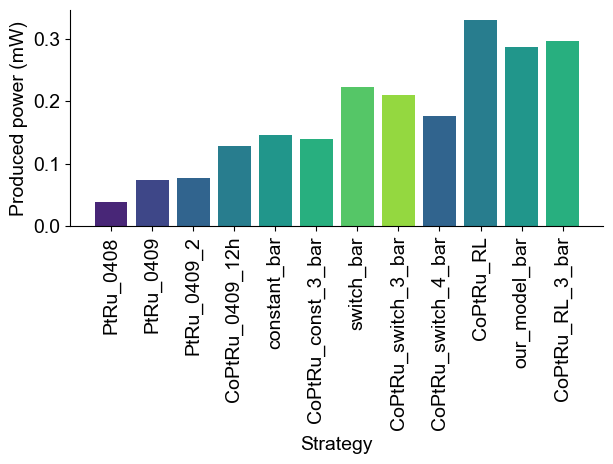

In [342]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(
    ['PtRu_0408', 'PtRu_0409', 'PtRu_0409_2', 'CoPtRu_0409_12h', 'constant_bar','CoPtRu_const_3_bar',
     'switch_bar','CoPtRu_switch_3_bar', 'CoPtRu_switch_4_bar', 'CoPtRu_RL', 'our_model_bar', 'CoPtRu_RL_3_bar'],
    [PtRu_0408_bar, PtRu_0409_bar, PtRu_0409_2_bar, CoPtRu_0409_12h_bar, constant_bar,CoPtRu_const_3_bar,  switch_bar,  CoPtRu_switch_3_bar, CoPtRu_switch_4_bar, CoPtRu_RL_bar, our_model_bar,CoPtRu_RL_3_bar],
    color=[ '#482677', '#3E4788',  '#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840','#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840', '#94D840'])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.tight_layout()

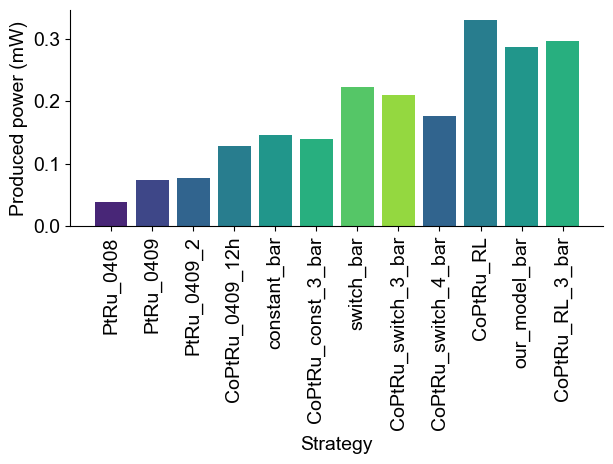

In [336]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(
    ['PtRu_0408', 'PtRu_0409', 'PtRu_0409_2', 'CoPtRu_0409_12h', 'constant_bar','CoPtRu_const_3_bar',
     'switch_bar','CoPtRu_switch_3_bar', 'CoPtRu_switch_4_bar', 'CoPtRu_RL', 'our_model_bar', 'CoPtRu_RL_3_bar'],
    [PtRu_0408_bar, PtRu_0409_bar, PtRu_0409_2_bar, CoPtRu_0409_12h_bar, constant_bar,CoPtRu_const_3_bar,  switch_bar,  CoPtRu_switch_3_bar, CoPtRu_switch_4_bar, CoPtRu_RL_bar, our_model_bar,CoPtRu_RL_3_bar],
    color=[ '#482677', '#3E4788',  '#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840','#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840', '#94D840'])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_commercial.png', dpi=300, transparent=True)

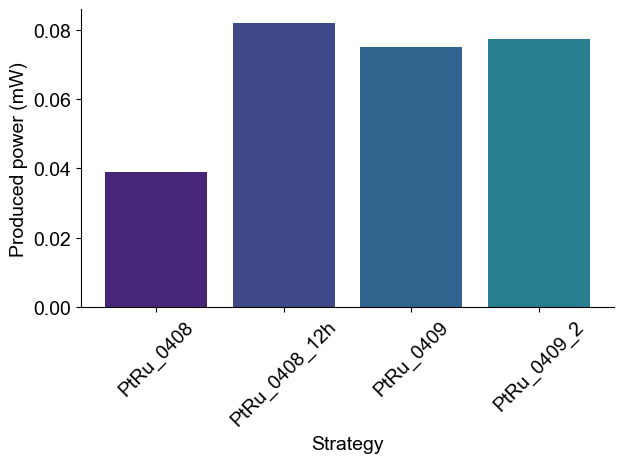

In [266]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(
    ['PtRu_0408', 'PtRu_0408_12h', 'PtRu_0409', 'PtRu_0409_2',],
    [PtRu_0408_bar, PtRu_0408_12h_bar, PtRu_0409_bar, PtRu_0409_2_bar, ],
    color=[ '#482677', '#3E4788',  '#31648E',  '#287D8E'])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_commercial.png', dpi=300, transparent=True)

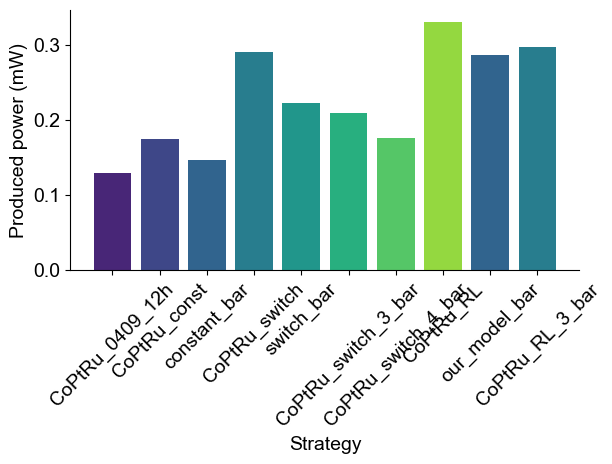

In [268]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots()
ax.bar(
    [ 'CoPtRu_0409_12h', 'CoPtRu_const', 'constant_bar', 'CoPtRu_switch','switch_bar',  'CoPtRu_switch_3_bar', 'CoPtRu_switch_4_bar', 'CoPtRu_RL', 'our_model_bar', 'CoPtRu_RL_3_bar'],
    [CoPtRu_0409_12h_bar, CoPtRu_const_bar, constant_bar, CoPtRu_switch_bar, switch_bar,  CoPtRu_switch_3_bar, CoPtRu_switch_4_bar, CoPtRu_RL_bar,  our_model_bar, CoPtRu_RL_3_bar],
    color=[ '#482677', '#3E4788',  '#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840','#31648E',  '#287D8E',  '#21968B', '#28AF7F',  '#55C667', '#94D840'])
plt.ylabel('Produced power (mW)', fontsize=14)
plt.xlabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_commercial.png', dpi=300, transparent=True)

In [102]:
ref_potential = -0.263
const_12h = csv2json('D:\\hongbin\\20240409_CoPtRu_constant_12hours\\exp0_1_2024-04-08_20-36-53_C01.csv')
PtRu_0408_12h = csv2json('D:\\hongbin\\20240408_PtRu_12hours\\exp0_1_2024-04-08_20-44-13_C01.csv')
RL_new_12h = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')
switch_12h = csv2json('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv')

In [103]:
calc_time(const_12h)
calc_time(PtRu_0408_12h)
calc_time(RL_new_12h)
calc_time(switch_12h)

In [91]:
print(find_offset(switch_12h, 0.35))
print(find_offset(PtRu_0408_12h, 0.35))
print(find_offset(RL_new_12h, 0.35))
print(find_offset(const_12h, 0.35))

610.0
152.5
1477.484268228578
305.0


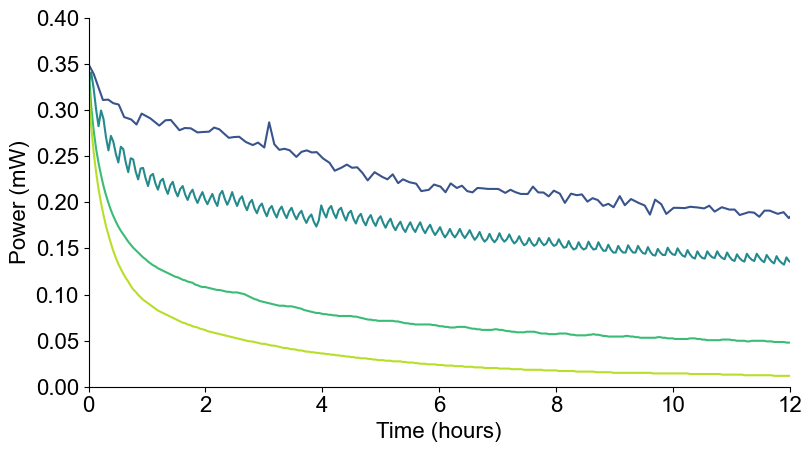

In [218]:
plt.rc('font', family='Arial', size=16)
color = ['#39548C', '#258A8D', '#3BBC75', '#B8DE28']

fig, ax = plt.subplots(figsize=(8.4,4.8))
ax.plot((RL_new_12h['time']-find_offset(RL_new_12h, 0.35))/3600, RL_new_12h['reward'], label='RL_new_12h strategy', color=color[0])
ax.plot((switch_12h['time']-find_offset(switch_12h, 0.35))/3600, switch_12h['reward'], label='switch_12h strategy', color=color[1])
ax.plot((const_12h['time']-find_offset(const_12h, 0.35))/3600, const_12h['reward'], label='Const_12h strategy', color = color[2])
ax.plot((PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35))/3600, PtRu_0408_12h['reward'], label='PtRu_0408_12h strategy', color = color[3])

# ax.legend(fontsize=12, ncol=2)
# ax.legend(fontsize=12, bbox_to_anchor=(1,1))
# ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Power (mW)', fontsize=16)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 0.4)
plt.xlim(0, 720/60)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel_commercial.png', dpi=300, transparent=True)

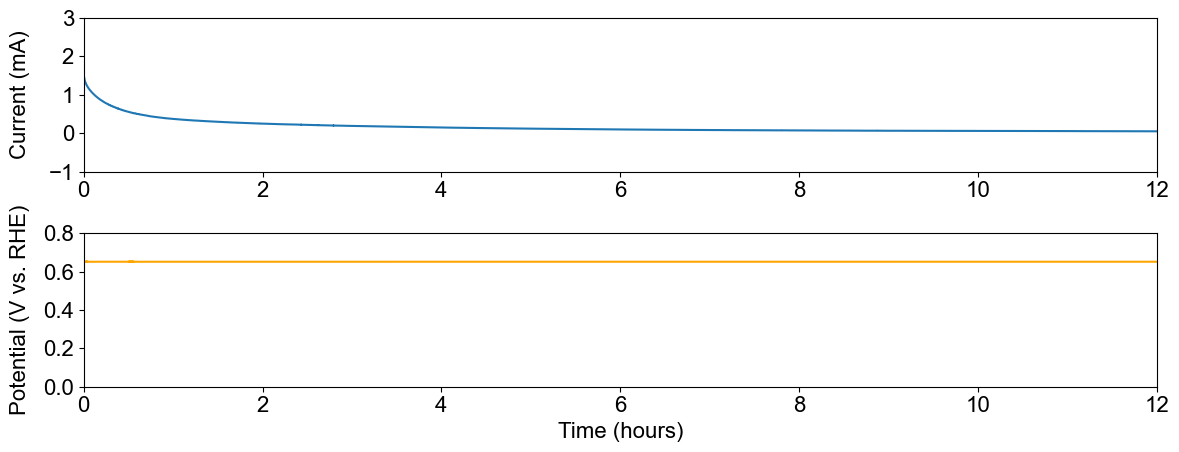

In [390]:
df = pd.read_csv('D:\\hongbin\\20240408_PtRu_12hours\\exp0_1_2024-04-08_20-44-13_C01.csv', sep=';')
# const_12h = csv2json('D:\\hongbin\\20240409_CoPtRu_constant_12hours\\exp0_1_2024-04-08_20-36-53_C01.csv')
# PtRu_0408_12h = csv2json('D:\\hongbin\\20240408_PtRu_12hours\\exp0_1_2024-04-08_20-44-13_C01.csv')
# RL_new_12h = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')
# switch_12h = csv2json('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv')
fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(df['time/s']/3600, df['I/mA'])
ax[0].set_ylim(0, 2)
ax[0].set_xlim(0, 12)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)
ax[1].plot(df['time/s']/3600, df['Ewe/V']-ref_potential, color='orange')
ax[1].set_xlim(0, 12)
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].set_xlabel('Time (hours)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
ax[0].set_yticks([-1,0,1,2,3])
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\PtRu_curr_vs_pot_12h.png', dpi=300, transparent=True)

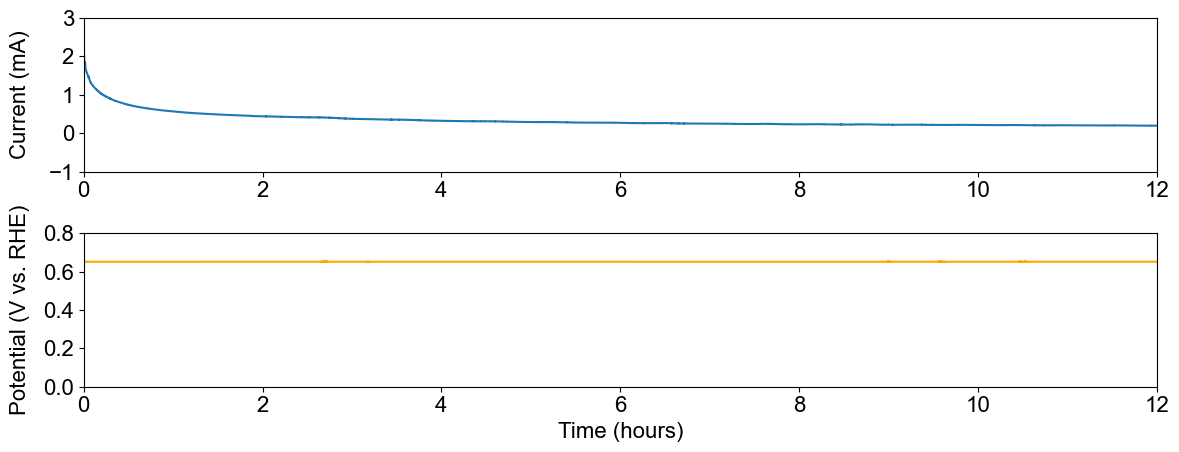

In [391]:
df = pd.read_csv('D:\\hongbin\\20240409_CoPtRu_constant_12hours\\exp0_1_2024-04-08_20-36-53_C01.csv', sep=';')
# const_12h = csv2json('D:\\hongbin\\20240409_CoPtRu_constant_12hours\\exp0_1_2024-04-08_20-36-53_C01.csv')
# PtRu_0408_12h = csv2json('D:\\hongbin\\20240408_PtRu_12hours\\exp0_1_2024-04-08_20-44-13_C01.csv')
# RL_new_12h = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')
# switch_12h = csv2json('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv')
fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(df['time/s']/3600, df['I/mA'])
ax[0].set_ylim(0, 2)
ax[0].set_xlim(0, 12)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)
ax[1].plot(df['time/s']/3600, df['Ewe/V']-ref_potential, color='orange')
ax[1].set_xlim(0, 12)
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].set_xlabel('Time (hours)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
ax[0].set_yticks([-1,0,1,2,3])
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\CoPtRu_curr_vs_pot_12h.png', dpi=300, transparent=True)

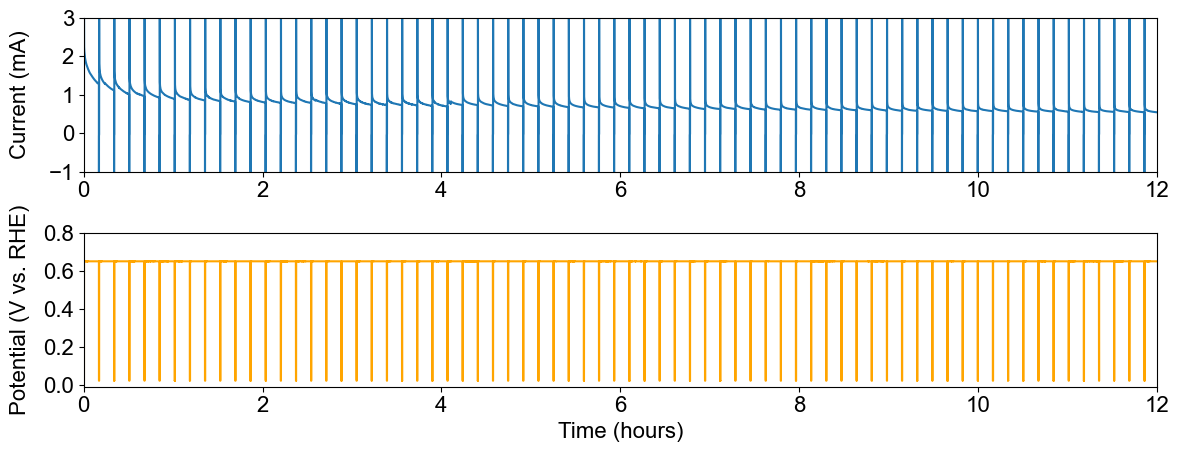

In [392]:
df = pd.read_csv('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv', sep=';')
# const_12h = csv2json('D:\\hongbin\\20240409_CoPtRu_constant_12hours\\exp0_1_2024-04-08_20-36-53_C01.csv')
# PtRu_0408_12h = csv2json('D:\\hongbin\\20240408_PtRu_12hours\\exp0_1_2024-04-08_20-44-13_C01.csv')
# RL_new_12h = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')
# switch_12h = csv2json('D:\\hongbin\\20240404_switch\\exp0_1_2024-04-04_21-38-13_C01.csv')
fig, ax = plt.subplots(2,1, figsize=(12,4.8))
ax[0].plot(df['time/s']/3600, df['I/mA'])
ax[0].set_ylim(-1, 3)
ax[0].set_xlim(0, 12)
ax[0].set_ylabel('Current (mA)')
ax[0].yaxis.set_label_coords(-0.05, 0.5)
ax[1].plot(df['time/s']/3600, df['Ewe/V']-ref_potential, color='orange')
ax[1].set_xlim(0, 12)
ax[1].set_ylabel('Potential (V vs. RHE)')
ax[1].set_xlabel('Time (hours)')
ax[1].yaxis.set_label_coords(-0.05, 0.5)
ax[0].set_yticks([-1,0,1,2,3])
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8])
# plt.xlim(0,10000)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\CoPtRu_swi_curr_vs_pot_12h.png', dpi=300, transparent=True)

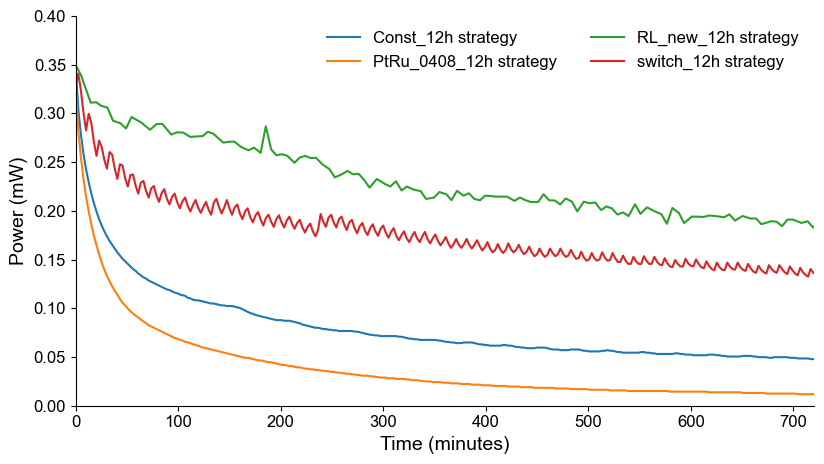

In [93]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots(figsize=(8.4,4.8))
ax.plot((const_12h['time']-find_offset(const_12h, 0.35))/60, const_12h['reward'], label='Const_12h strategy')
ax.plot((PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35))/60, PtRu_0408_12h['reward'], label='PtRu_0408_12h strategy')
ax.plot((RL_new_12h['time']-find_offset(RL_new_12h, 0.35))/60, RL_new_12h['reward'], label='RL_new_12h strategy')
ax.plot((switch_12h['time']-find_offset(switch_12h, 0.35))/60, switch_12h['reward'], label='switch_12h strategy')

ax.legend(fontsize=12, ncol=2)
# ax.legend(fontsize=12, bbox_to_anchor=(1,1))
ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Power (mW)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 0.4)
plt.xlim(0, 720)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel_commercial.png', dpi=300, transparent=True)

In [159]:
const_12h_bar = const_12h[(const_12h['time']-find_offset(const_12h, 0.35)<60*720)&(const_12h['time']-find_offset(const_12h, 0.35)>0)]['reward'].mean()
PtRu_0408_12h_bar = PtRu_0408_12h[(PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35)<60*720)&(PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35)>0)]['reward'].mean()
RL_new_12h_bar = RL_new_12h[(RL_new_12h['time']-find_offset(RL_new_12h, 0.35)<60*720)&(RL_new_12h['time']-find_offset(RL_new_12h, 0.35)>0)]['reward'].mean()
switch_12h_bar = switch_12h[(switch_12h['time']-find_offset(switch_12h, 0.35)<60*720)&(switch_12h['time']-find_offset(switch_12h, 0.35)>0)]['reward'].mean()
print('Constant strategy: ', const_12h_bar)
print('Commercial catalyst: ', PtRu_0408_12h_bar)
print('Ours: ', RL_new_12h_bar)
print('Switching strategy: ', switch_12h_bar)

Constant strategy:  0.08087354457510282
Commercial catalyst:  0.03935816486126398
Ours:  0.23067121051583334
Switching strategy:  0.17688930081677579


In [104]:
const_12h_bar = const_12h[(const_12h['time']-find_offset(const_12h, 0.35)<60*720)&(const_12h['time']-find_offset(const_12h, 0.35)>0)]['reward'].mean()
PtRu_0408_12h_bar = PtRu_0408_12h[(PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35)<60*720)&(PtRu_0408_12h['time']-find_offset(PtRu_0408_12h, 0.35)>0)]['reward'].mean()
RL_new_12h_bar = RL_new_12h[(RL_new_12h['time']-find_offset(RL_new_12h, 0.35)<60*720)&(RL_new_12h['time']-find_offset(RL_new_12h, 0.35)>0)]['reward'].mean()
switch_12h_bar = switch_12h[(switch_12h['time']-find_offset(switch_12h, 0.35)<60*720)&(switch_12h['time']-find_offset(switch_12h, 0.35)>0)]['reward'].mean()
print('Constant strategy: ', const_12h_bar)
print('Commercial catalyst: ', PtRu_0408_12h_bar)
print('Ours: ', RL_new_12h_bar)
print('Switching strategy: ', switch_12h_bar)

Constant strategy:  0.08087354457510282
Commercial catalyst:  0.03935816486126398
Ours:  0.23067121051583334
Switching strategy:  0.17688930081677579


In [326]:
(0.23067121051583334-0.08087354457510282)/0.08087354457510282*100, (0.23067121051583334-0.03935816486126398)/0.03935816486126398*100, (0.23067121051583334-0.17688930081677579)/0.17688930081677579*100,

(185.2245585719588, 486.0822305332083, 30.404275131804354)

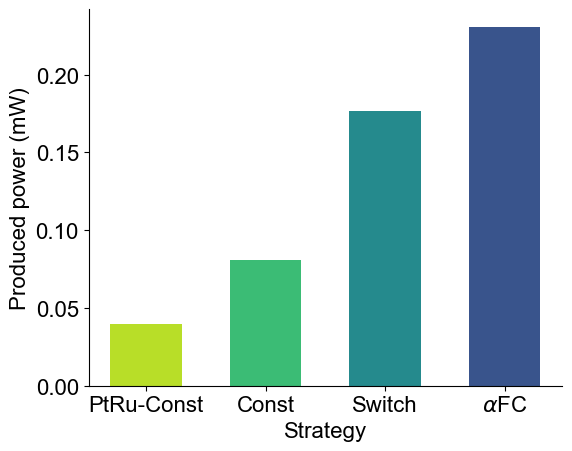

In [106]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(6,4.8))
ax.bar(
    ['PtRu-Const', 'Const', 'Switch', r'$\alpha$FC'],
    [PtRu_0408_12h_bar, const_12h_bar, switch_12h_bar, RL_new_12h_bar ],
    color=color[::-1], width=0.6)
plt.ylabel('Produced power (mW)', fontsize=16)
plt.xlabel('Strategy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_all_12h.png', dpi=300, transparent=True)

In [322]:
0.28419/0.06113, 0.28419/0.13245, (0.28419-0.19822)/0.19822*100

(4.6489448715851465, 2.14563986409966, 43.37100191706185)

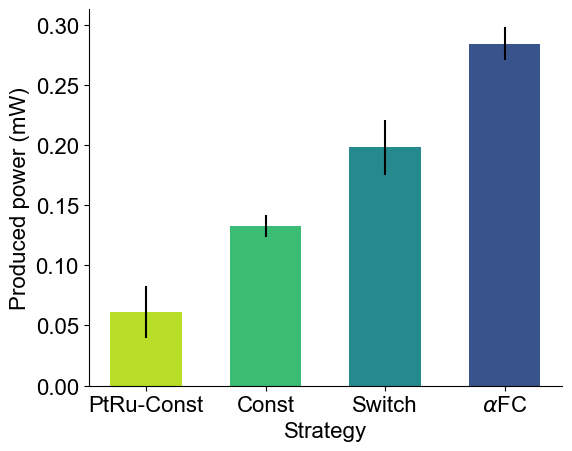

In [98]:

[0.06113, 0.13245, 0.19822, 0.28419]
[0.02138, 0.00901, 0.02286, 0.01387]
plt.rc('font', family='Arial', size=16)
# plt.figure(figsize=(4.8,4.8))
color = ['#39548C', '#258A8D', '#3BBC75', '#B8DE28']

fig, ax = plt.subplots(figsize=(6,4.8))
ax.bar(
    ['PtRu-Const', 'Const', 'Switch', r'$\alpha$FC'],
    [0.06113, 0.13245, 0.19822, 0.28419],
    yerr=[0.02138, 0.00901, 0.02286, 0.01387],
    color=color[::-1], width=0.6)#[ '#482677', '#3E4788',  '#31648E',  '#287D8E'])
plt.ylabel('Produced power (mW)', fontsize=16)
plt.xlabel('Strategy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_all.png', dpi=300, transparent=True)

In [443]:
torch.tensor(our_model['state'].iloc[0])

tensor([[0.1384, 0.1384, 0.1384,  ..., 0.3887, 0.3887, 0.3887],
        [0.5005, 0.3132, 0.1561,  ..., 1.6298, 1.6296, 1.6295]])

In [436]:
real_device = pd.read_json('D:\\hongbin\\20240417_commercial_DMFC\\real_database.json')

In [444]:
0.9-0.263

0.637

In [454]:
torch.tensor(real_device['state'].iloc[i])/torch.tensor([[1],[50]])torch.tensor([[0.637],[0]])

tensor([[-2.3565e-01, -2.3560e-01, -2.3559e-01,  ...,  3.8850e-01,
          3.8853e-01,  3.8853e-01],
        [-2.6352e-05, -1.1593e-05, -1.0070e-05,  ...,  3.5855e-04,
          3.5859e-04,  3.5859e-04]])

In [446]:
prediction_model = []
with torch.no_grad():
    for i in range(len(real_device)):
        pred = model((torch.tensor(real_device['state'].iloc[i])/torch.tensor([[1],[50]])+torch.tensor([[0.637],[0]])).unsqueeze(0), torch.tensor(real_device['action'].iloc[i]).unsqueeze(0))
        prediction_model.append(pred.item())

In [455]:
real_device['action']
# real_device['state']

0                  [0.400000006, 0.6499999762, 1.0, 2.5]
1                  [0.400000006, 0.6499999762, 1.0, 2.5]
2      [0.400000006, 0.6499999762, 0.3839110732, 2.29...
3      [0.400000006, 0.6499999762, 0.3319388330000000...
4      [0.400000006, 0.6499999762, 0.3100000024000000...
                             ...                        
133    [0.019999999600000002, 0.6499999762, 0.8766556...
134    [0.400000006, 0.6499999762, 0.5387258530000001...
135    [0.040672235200000004, 0.6499999762, 0.3100000...
136    [0.0255014393, 0.6499999762, 0.310000002400000...
137    [0.400000006, 0.5773010254000001, 0.9024413824...
Name: action, Length: 138, dtype: object

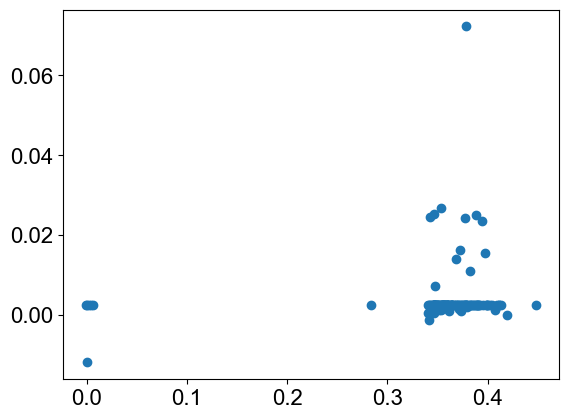

In [448]:
plt.scatter(real_device['reward']/50, prediction_model)

In [387]:
why = pd.read_csv('D:\\hongbin\\20240417_commercial_DMFC\\exp7_5_2024-04-19_11-03-55_C01.csv', sep=';')
len(why)

3180

In [389]:
why
# plt.plot(why['time/s'], why['Ewe/V'])

,time/s,Ewe/V,I/mA
0,0.1572,-0.857618,-41.821724
1,0.2572,-0.857595,-32.470006
2,0.3572,-0.857541,-25.783811
3,0.4572,-0.857553,-23.516308
4,0.5572,-0.857591,-22.131567
...,...,...,...
3175,317.6000,-0.248496,68.747425
3176,317.7000,-0.248499,68.761453
3177,317.8000,-0.248450,68.745754
3178,317.9000,-0.248473,68.738273


In [91]:
ours = pd.read_json('D:\\hongbin\\20240417_commercial_DMFC\\real_database.json')
constant = csv2json('D:\\hongbin\\20240416_commercial_DMFC\\06_CA_PtRu_Pt_1M_100O2H_5_60C_C01.csv')


In [92]:
calc_time(ours)
calc_time(constant)

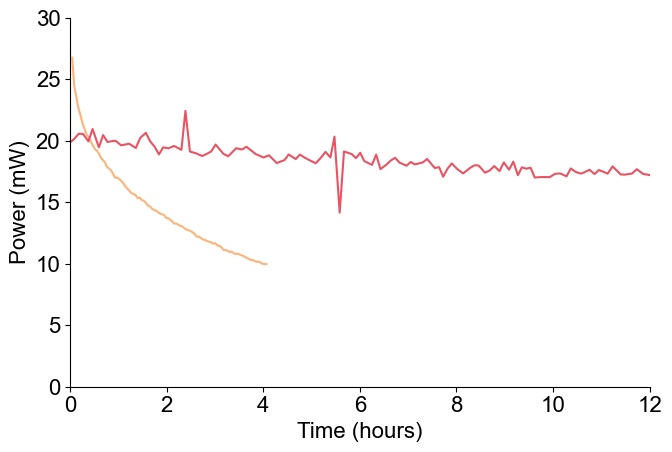

In [246]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(7,4.8))
ax.plot((constant['time'])/3600, constant['reward'], label='Constant', color='#FEB37B')
ax.plot((ours['time'])/3600-30/60, ours['reward'], label='AFC', color='#E95362')
#E95362,
# ax.legend(fontsize=12, ncol=2)
# # ax.legend(fontsize=12, bbox_to_anchor=(1,1))
# ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Power (mW)', fontsize=16)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 30)
plt.xlim(0, 12)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel_commercial.png', dpi=300, transparent=True)

In [93]:
constant_bar = constant[constant['time']<60*240]['reward'].mean()
ours_bar = ours[(ours['time']-30*60<60*240)&(ours['time']-30*60>0)]['reward'].mean()
print('Constant strategy: ', constant_bar)
print('Ours :', ours_bar)

Constant strategy:  14.596895709801183
Ours : 19.6927138075


In [324]:
(19.6927-14.5968)/14.5968

0.34911076400306906

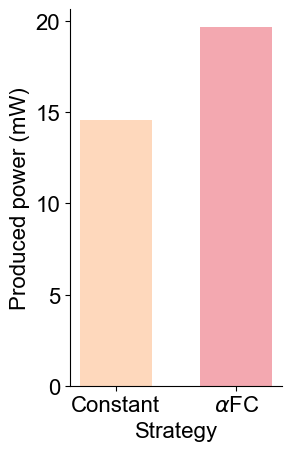

In [95]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(3.2,4.8))
ax.bar(
    ['Constant', r'$\alpha$FC'],
    [constant_bar, ours_bar ],
    color=['#FEB37B', '#E95362',], width=0.6, alpha=0.5)
plt.ylabel('Produced power (mW)', fontsize=16)
plt.xlabel('Strategy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_commercial.png', dpi=300, transparent=True)

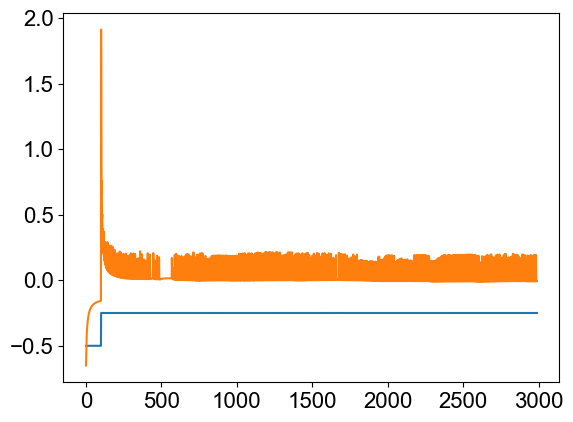

In [423]:
plt.plot(ours['state'].iloc[1][0])
plt.plot(ours['state'].iloc[1][1])

# April 26

In [79]:
ref_potential = -0.9
ours = pd.read_json('D:\\hongbin\\20240424_CoPtRu_DMFC\\real_database.json')
constant = csv2json('D:\\hongbin\\20240424_CoPtRu_DMFC\\19_CA_CoPtRu_Pt_1M_40O2H_5_60C_C01.csv')


In [80]:
calc_time(ours)
calc_time(constant)

In [50]:
ours['time'].max()

57085.08681573501

In [82]:
new_time = []
for time in ours['time'].iloc:
    if time < 9566:
        time = time
    else:
        time = time - 2010
    new_time.append(time)

ours['time'] = new_time
ours = ours[ours['reward'] > 20]


In [83]:
ours['time'].max()

55075.08681573501

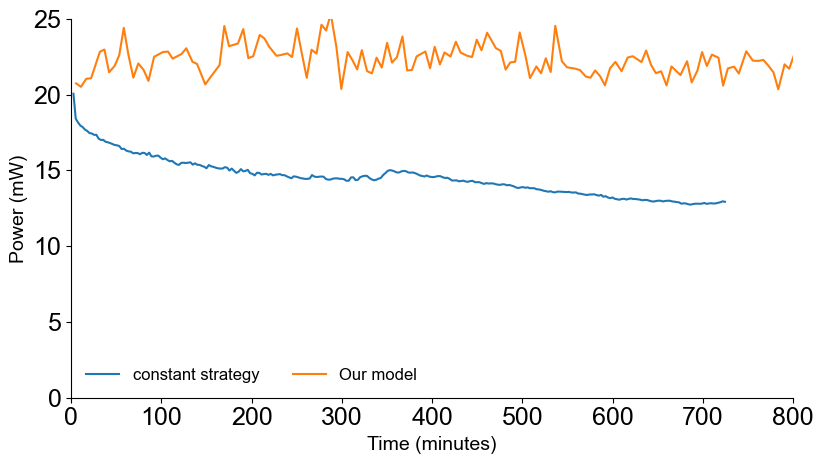

In [84]:
plt.rc('font', family='Arial', size=12)

fig, ax = plt.subplots(figsize=(8.4,4.8))
ax.plot((constant['time'])/60, constant['reward'], label='constant strategy')
ax.plot((ours['time'])/60, ours['reward'], label='Our model')

ax.legend(fontsize=12, ncol=2)
# ax.legend(fontsize=12, bbox_to_anchor=(1,1))
ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Power (mW)', fontsize=14)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 25)
plt.xlim(0, 800)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel_commercial.png', dpi=300, transparent=True)

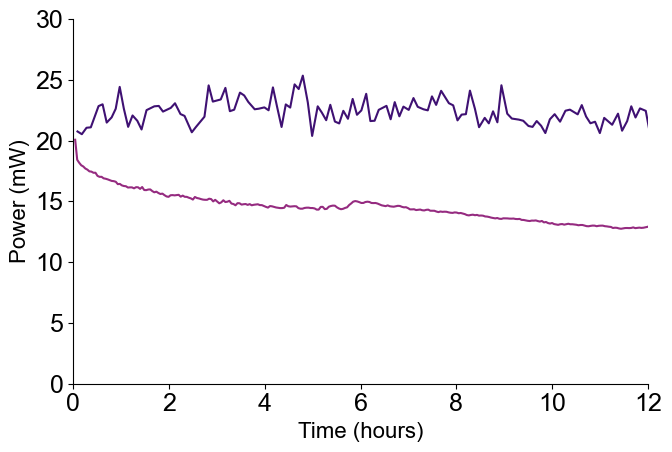

In [85]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(7,4.8))
ax.plot((constant['time'])/3600, constant['reward'], label='Constant',  color='#952B80')
ax.plot((ours['time'])/3600, ours['reward'], label='AFC', color='#3F1173')
#3F1173, #952B80,
# ax.legend(fontsize=12, ncol=2)
# ax.legend(fontsize=12, bbox_to_anchor=(1,1))
# ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Power (mW)', fontsize=16)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 30)
plt.xlim(0, 12)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\comparison_constant_ourmodel_commercial_2.png', dpi=300, transparent=True)

In [86]:
constant_bar = constant[constant['time']<60*12*60]['reward'].mean()
ours_bar = ours[ours['time']<60*12*60]['reward'].mean()
print('Constant strategy: ', constant_bar)
print('Ours :', ours_bar)

Constant strategy:  14.538205410415339
Ours : 22.358500021543694


In [325]:
(22.3585-14.5382)/14.5382

0.5379139095623943

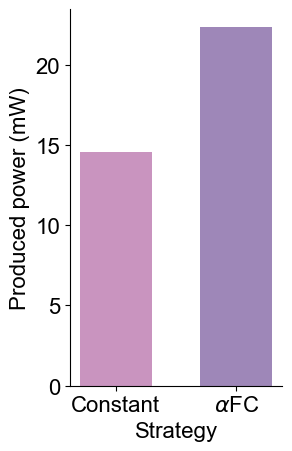

In [90]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(3.2,4.8))
ax.bar(
    ['Constant', r'$\alpha$FC'],
    [constant_bar, ours_bar ],
    color=['#952B80', '#3F1173', ], width=0.6, alpha=0.5)
plt.ylabel('Produced power (mW)', fontsize=16)
plt.xlabel('Strategy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\power_bat_plot_commercial_2.png', dpi=300, transparent=True)


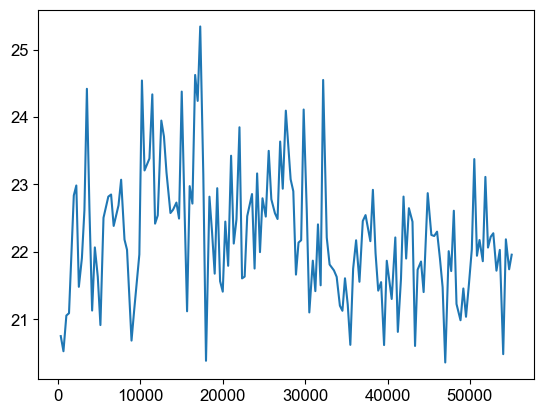

In [443]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from conduct_rl_training import GAActor, MLData
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score


class MLData(torch.utils.data.Dataset):
    '''
    Dataset for DMFC
    Trajectory data: (2, 2990)
        it should be used as next state
    State data: (2,)
    Action data: (4,)
    Reward data: (1,)
    '''

    def __init__(self, data_dir, start, end, augment=None):
        df = pd.read_json(os.path.join(data_dir, 'real_database.json')).iloc[:] # load database
        print(len(df))
        self.df = df[df['state'].apply(lambda x: np.array(x).shape == (2, 2990))]
        # self.df = self.df.loc[start:end]
        print(len(self.df))
        if augment:
            # choose last 1000 data
            # self.df = self.df.iloc[-1000:]
            idx = [2578]  # incontinuous index
            # split dataframe according to idx
            df_splits = []
            for i in range(len(idx)+1):  # +1 for the last part
                if i == 0:
                    df_splits.append(self.df.loc[:idx[i]-1])
                elif i == len(idx):
                    df_splits.append(self.df.loc[idx[i-1]:])
                else:
                    df_splits.append(self.df.loc[idx[i-1]:idx[i]-1])
            Xs = []
            actions = []
            Ys = []
            for df in df_splits:
                print(len(df))
                Xs.append(df['state'].to_numpy()[1:])
                actions.append(df['action'].to_numpy()[:-1])
                Ys.append(df['reward'].to_numpy()[:-1])
                Xs.append(df['state'].to_numpy()[:-1])
                actions.append(df['action'].to_numpy()[1:])
                Ys.append(df['reward'].to_numpy()[1:])
            for df in df_splits:
                Xs.append(df['state'].to_numpy())
                actions.append(df['action'].to_numpy())
                Ys.append(df['reward'].to_numpy())
            self.X = np.concatenate(Xs)
            self.action = np.concatenate(actions)
            self.Y = np.concatenate(Ys)
        else:
            self.X = self.df['state'].to_numpy()
            self.action = self.df['action'].to_numpy()
            self.Y = self.df['reward'].to_numpy()

    def __getitem__(self, index):
        return np.array(self.X[index]).astype(np.float32), \
            np.array(self.action[index]).astype(np.float32), \
            self.Y[index].astype(np.float32)

    def __len__(self):
        return len(self.X)


# mldata = MLData('/home/yj/PycharmProjects/MIT/MOR_RL2/logs/asdf')
## last 300 points are test dataset. The rest is train and val dataset, which is split randomly with 9:1 ratio and seed 42
# test_idx = range(len(mldata)-300, len(mldata))
# # torch random sample
# torch.manual_seed(42)
# train_idx = torch.randperm(len(mldata)-300)[:int(0.9 * (len(mldata)-300))]
# val_idx = torch.randperm(len(mldata)-300)[int(0.9 * (len(mldata)-300)):]
# test_dataset = torch.utils.data.Subset(mldata, test_idx)
# train_dataset = torch.utils.data.Subset(mldata, train_idx)
# val_dataset = torch.utils.data.Subset(mldata, val_idx)
# train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32)
# num=1717
train_valid_dataset = MLData('D:\\hongbin\\20231207_real_MOR', 0, -1, augment=False)
# test_dataset = MLData('/home/yj/PycharmProjects/MIT/MOR_RL2/logs/asdf', 1717, 2017, augment=False)
# torch random sample
torch.manual_seed(42)
train_idx = torch.randperm(len(train_valid_dataset))[:int(0.9 * (len(train_valid_dataset)))]
val_idx = torch.randperm(len(train_valid_dataset))[int(0.9 * (len(train_valid_dataset))):]
train_dataset = torch.utils.data.Subset(train_valid_dataset, train_idx)
val_dataset = torch.utils.data.Subset(train_valid_dataset, val_idx)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32)

7633
7626


In [401]:
df = pd.read_json(os.path.join('D:\\hongbin\\20231207_real_MOR', 'real_database.json'))  # load database
df

,state,action,new_state,reward,done,order
0,"[[-0.1419358104, -0.1419396251, -0.1419090629,...","[0.400000006, 0.600744009, 0.31724923850000003...","[[0.1381726116, 0.1381420493, 0.13818407060000...",0.035556,False,"{'step_id': 'exp0_3', 'step_actual_time': (300..."
1,"[[0.1381726116, 0.1381420493, 0.13818407060000...","[0.1873060167, 0.3654167652, 0.8305803537, 1.9...","[[-0.07490918790000001, -0.0749244615, -0.0749...",-0.000255,False,"{'step_id': 'exp0_4', 'step_actual_time': (392..."
2,"[[-0.07490918790000001, -0.0749244615, -0.0749...","[0.2374180108, 0.200000003, 0.7549267411, 1.46...","[[-0.0249572229, -0.0249915998, -0.0250145197,...",-0.004161,False,"{'step_id': 'exp0_5', 'step_actual_time': (312..."
3,"[[-0.0249572229, -0.0249915998, -0.0250145197,...","[0.20025810600000002, 0.2129244208, 0.77506548...","[[-0.061986684800000004, -0.061925571400000004...",-0.004639,False,"{'step_id': 'exp0_6', 'step_actual_time': (431..."
4,"[[-0.061986684800000004, -0.061925571400000004...","[0.1059096605, 0.200000003, 0.9035623074, 1.92...","[[-0.1559278667, -0.1559545994, -0.1559584141,...",-0.004378,False,"{'step_id': 'exp0_7', 'step_actual_time': (365..."
...,...,...,...,...,...,...
7628,"[[-0.24148796500000003, -0.2414841503, -0.2414...","[0.019999999600000002, 0.6499999762, 0.3100000...","[[-0.241510883, -0.241476506, -0.2414574027000...",-0.091006,False,"{'step_id': 'exp292_21', 'step_actual_time': (..."
7629,"[[-0.241510883, -0.241476506, -0.2414574027000...","[0.019999999600000002, 0.6499999762, 0.3100000...","[[-0.2414688617, -0.241442129, -0.2414612323, ...",-0.091006,False,"{'step_id': 'exp292_22', 'step_actual_time': (..."
7630,"[[-0.2414688617, -0.241442129, -0.2414612323, ...","[0.019999999600000002, 0.6499999762, 0.3100000...","[[-0.2415070534, -0.2414955944, -0.24152615670...",-0.091337,False,"{'step_id': 'exp292_23', 'step_actual_time': (..."
7631,"[[-0.2415070534, -0.2414955944, -0.24152615670...","[0.019999999600000002, 0.6499999762, 0.3100000...","[[-0.2414803207, -0.2415452749, -0.24152234200...",-0.091668,True,"{'step_id': 'exp292_24', 'step_actual_time': (..."


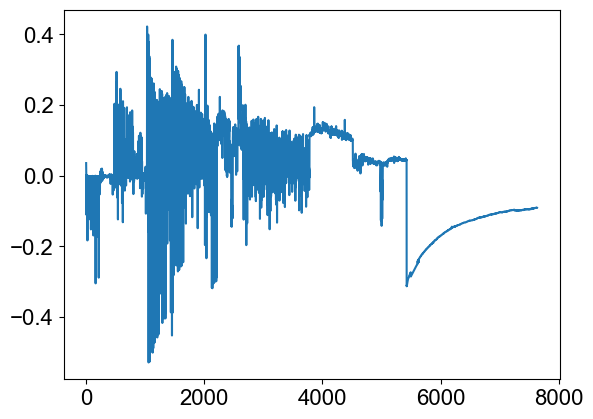

In [452]:
plt.plot(df.iloc[:]['reward'])

In [478]:
# CoPtRu_const_3 = csv2json('D:\\hongbin\\20240412_CoPtRu_constant_3\\exp0_1_2024-04-12_14-11-25_C01.csv')
# our_model = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')

df = pd.read_csv('D:\\hongbin\\20240412_CoPtRu_constant_3\\exp0_1_2024-04-12_14-11-25_C01.csv', sep=';')
const_emb = []
while len(df) > 2990:
    X = torch.tensor(df.iloc[:2990][['Ewe/V','I/mA']].to_numpy(), dtype=torch.float32).transpose(1,0).unsqueeze(0)
    emb = model.cnn(X)
    const_emb.append(emb.cpu().detach().numpy())
    df = df.iloc[2990:]
# our_model = pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json')

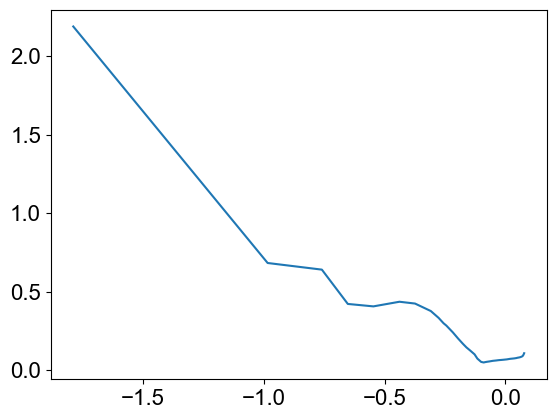

In [479]:
const_emb = np.concatenate(const_emb)
const_pca = pca.transform(const_emb)
plt.plot(const_pca[:,0], const_pca[:,1])

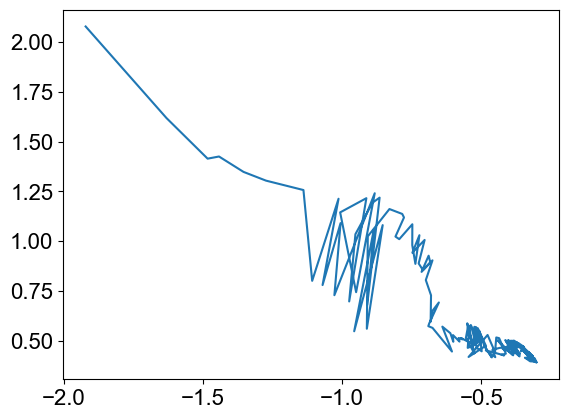

In [480]:
our_model_emb = []
for i, row in pd.read_json('D:\\hongbin\\20240405_RL_new\\real_database.json').iterrows():
    X = torch.tensor(row['state'], dtype=torch.float32).unsqueeze(0)
    emb = model.cnn(X)
    our_model_emb.append(emb.cpu().detach().numpy())
our_model_emb = np.concatenate(our_model_emb)
our_model_pca = pca.transform(our_model_emb)
plt.plot(our_model_pca[:,0], our_model_pca[:,1])

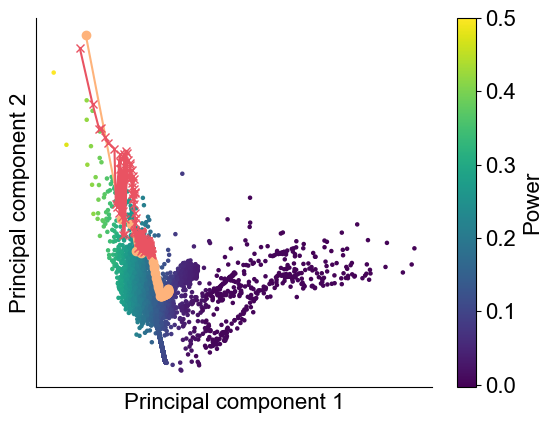

In [487]:
plt.scatter(train_tsne[:,0], train_tsne[:,1], s=5, c=rewards_action[0], cmap='viridis')#, vmin=0.0)
plt.plot(const_pca[:,0], const_pca[:,1], color='#FEB37B', marker='o')
plt.plot(our_model_pca[:, 0], our_model_pca[:, 1], color='#E95362', marker='x')

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Power')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


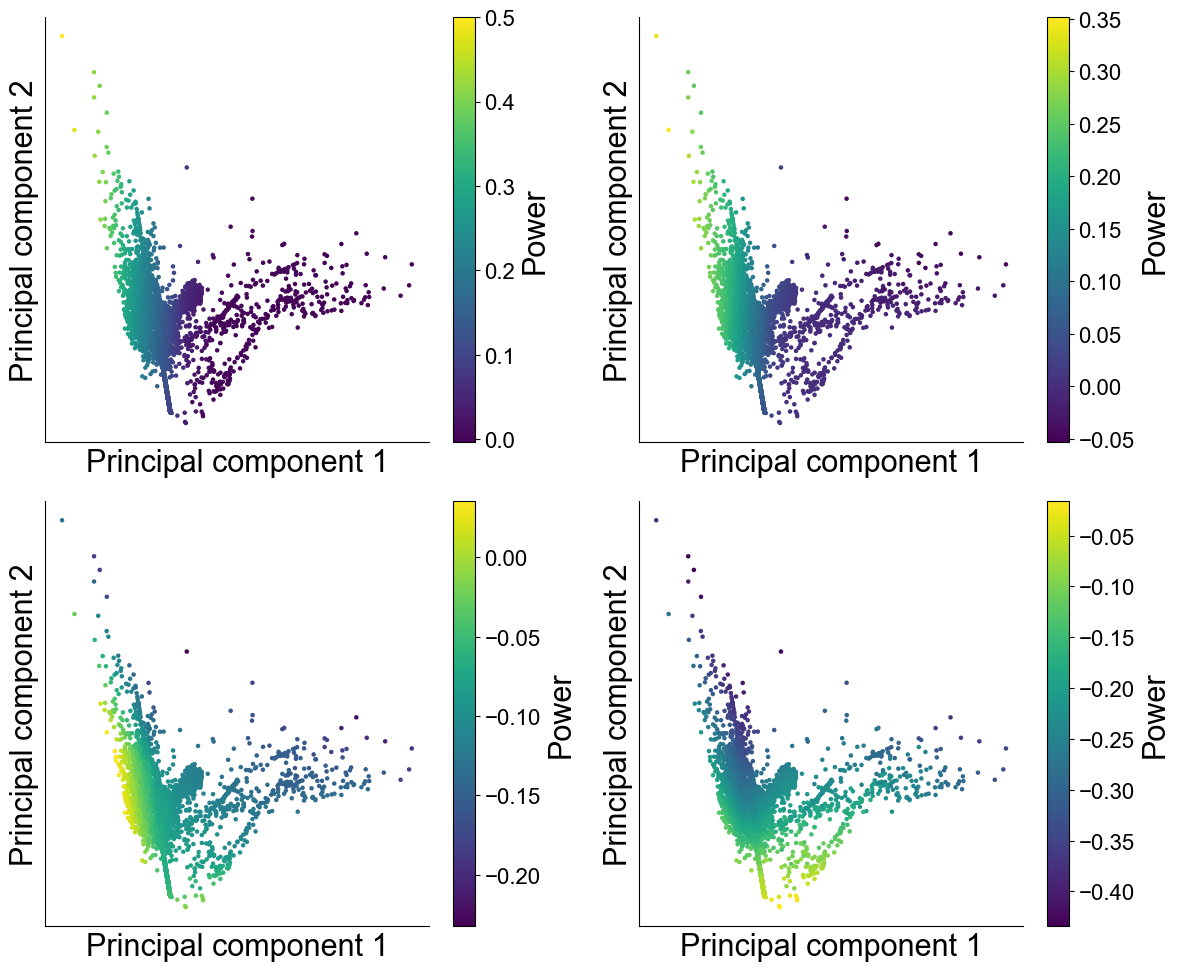

In [601]:
action_seeds = []
# action_seed = torch.tensor([0.4, 0.65, 1.0, 2.5]).to('cuda')
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(300))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(30))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(7))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(3))]))#.to('cuda'))

rewards_action = []

# font arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(12,10))#(24/1.5,5/1.5))
for i, action_seed in enumerate(action_seeds):
    # plot the training and validation data points
    train_embs = []
    train_pred = []
    val_embs = []
    val_pred = []
    test_embs = []
    test_pred = []
    model.eval()    # Set model to evaluate mode

    for batch in train_loader:
        X, action, Y = batch
        # X = X.to('cuda')
        action = action_seed.repeat(len(X), 1)#.to('cuda')
        # Y = Y.to('cuda')
        emb = model.cnn(X)
        output = model(X, action)
        train_embs.append(emb.squeeze().cpu().detach().numpy())
        train_pred.append(output.squeeze().cpu().detach().numpy())
    # for batch in val_loader:
    #     X, action, Y = batch
    #     X = X.to('cuda')
    #     action = action_seed.repeat(len(X), 1).to('cuda')
    #     Y = Y.to('cuda')
    #     emb = model.cnn(X)
    #     output = model(X, action)
    #     val_embs.append(emb.squeeze().cpu().detach().numpy())
    #     val_pred.append(output.squeeze().cpu().detach().numpy())
    # for batch in test_loader:
    #     X, action, Y = batch
    #     X = X.to('cuda')
    #     action = action_seed.repeat(len(X), 1).to('cuda')
    #     Y = Y.to('cuda')
    #     emb = model.cnn(X)
    #     output = model(X, action)
    #     test_embs.append(emb.squeeze().cpu().detach().numpy())
    #     test_pred.append(output.squeeze().cpu().detach().numpy())
    train_embs = np.concatenate(train_embs)
    train_pred = np.concatenate(train_pred)
    # val_embs = np.concatenate(val_embs)
    # val_pred = np.concatenate(val_pred)
    # test_embs = np.concatenate(test_embs)
    # test_pred = np.concatenate(test_pred)
    rewards_action.append(train_pred)

    # # PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    train_tsne = pca.fit_transform(train_embs)
    # from sklearn.manifold import TSNE
    # tsne = TSNE(n_components=2, random_state=42)
    # train_tsne = tsne.fit_transform(train_embs)

    # if i == 0:
    #     ax[0,0].plot(const_pca[:,0], const_pca[:,1], color='#FEB37B', marker='x')
    #     ax[0,0].plot(our_model_pca[:, 0], our_model_pca[:, 1], color='#E95362', marker='x')
    pcm = ax[i//2,i%2].scatter(train_tsne[:,0], train_tsne[:,1], s=5, c=train_pred, cmap='viridis')#, vmin=0.0)
    # colorbar label
    fig.colorbar(pcm, ax=ax[i//2,i%2], label='Power')
    ax[i//2,i%2].set_xlabel('Principal component 1')
    ax[i//2,i%2].set_ylabel('Principal component 2')
    # remove ticks
    ax[i//2,i%2].set_xticks([])
    ax[i//2,i%2].set_yticks([])
    # remove top and right spines
    ax[i//2,i%2].spines['top'].set_visible(False)
    ax[i//2,i%2].spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\pca.png', dpi=300, transparent=True)

In [497]:
np.log10(50)

1.6989700043360187

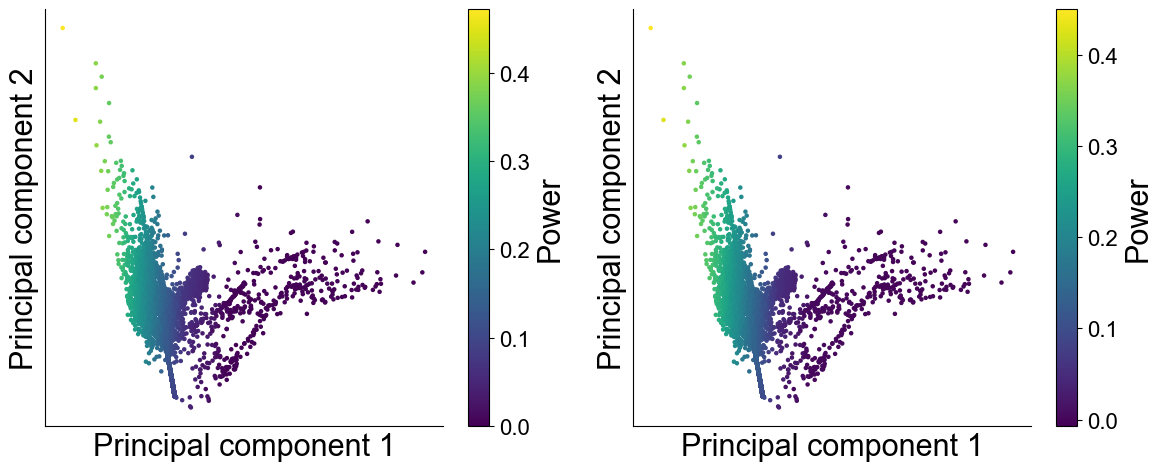

In [574]:
action_seeds = []
# action_seed = torch.tensor([0.4, 0.65, 1.0, 2.5]).to('cuda')
action_seeds.append(torch.tensor([0.65, 0.65, 0.31, float(np.log10(300))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.4, 0.65, 0.31, float(np.log10(60))]))#.to('cuda'))
# action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(7))]))#.to('cuda'))
# action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(3))]))#.to('cuda'))

rewards_action = []

# font arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(12,5))#(24/1.5,5/1.5))
for i, action_seed in enumerate(action_seeds):
    # plot the training and validation data points
    train_embs = []
    train_pred = []
    val_embs = []
    val_pred = []
    test_embs = []
    test_pred = []
    model.eval()    # Set model to evaluate mode

    for batch in train_loader:
        X, action, Y = batch
        # X = X.to('cuda')
        action = action_seed.repeat(len(X), 1)#.to('cuda')
        # Y = Y.to('cuda')
        emb = model.cnn(X)
        output = model(X, action)
        train_embs.append(emb.squeeze().cpu().detach().numpy())
        train_pred.append(output.squeeze().cpu().detach().numpy())
    # for batch in val_loader:
    #     X, action, Y = batch
    #     X = X.to('cuda')
    #     action = action_seed.repeat(len(X), 1).to('cuda')
    #     Y = Y.to('cuda')
    #     emb = model.cnn(X)
    #     output = model(X, action)
    #     val_embs.append(emb.squeeze().cpu().detach().numpy())
    #     val_pred.append(output.squeeze().cpu().detach().numpy())
    # for batch in test_loader:
    #     X, action, Y = batch
    #     X = X.to('cuda')
    #     action = action_seed.repeat(len(X), 1).to('cuda')
    #     Y = Y.to('cuda')
    #     emb = model.cnn(X)
    #     output = model(X, action)
    #     test_embs.append(emb.squeeze().cpu().detach().numpy())
    #     test_pred.append(output.squeeze().cpu().detach().numpy())
    train_embs = np.concatenate(train_embs)
    train_pred = np.concatenate(train_pred)
    # val_embs = np.concatenate(val_embs)
    # val_pred = np.concatenate(val_pred)
    # test_embs = np.concatenate(test_embs)
    # test_pred = np.concatenate(test_pred)
    rewards_action.append(train_pred)

    # # PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    train_tsne = pca.fit_transform(train_embs)
    # from sklearn.manifold import TSNE
    # tsne = TSNE(n_components=2, random_state=42)
    # train_tsne = tsne.fit_transform(train_embs)

    # if i == 0:
    #     ax[0,0].plot(const_pca[:,0], const_pca[:,1], color='#FEB37B', marker='x')
    #     ax[0,0].plot(our_model_pca[:, 0], our_model_pca[:, 1], color='#E95362', marker='x')
    pcm = ax[i%2].scatter(train_tsne[:,0], train_tsne[:,1], s=5, c=train_pred, cmap='viridis')#, vmin=0.0)
    # colorbar label
    fig.colorbar(pcm, ax=ax[i%2], label='Power')
    ax[i%2].set_xlabel('Principal component 1')
    ax[i%2].set_ylabel('Principal component 2')
    # remove ticks
    ax[i%2].set_xticks([])
    ax[i%2].set_yticks([])
    # remove top and right spines
    ax[i%2].spines['top'].set_visible(False)
    ax[i%2].spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\pca.png', dpi=300, transparent=True)

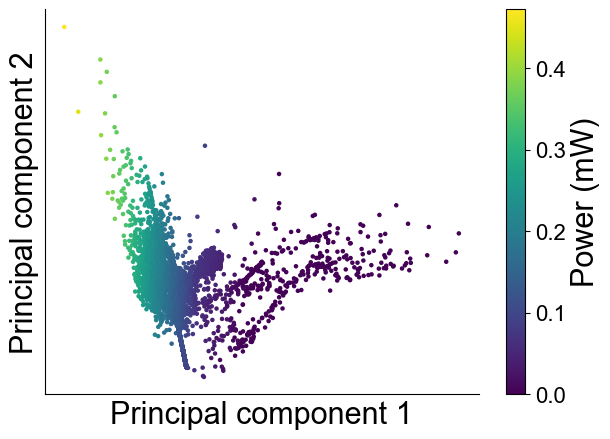

In [589]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7,5))
plt.scatter(train_tsne[:,0], train_tsne[:,1], s=5, c=rewards_action[0], cmap='viridis')#, vmin=-0.01, vmax=0.01)

plt.colorbar(label='Power (mW)')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# remove ticks
plt.xticks([])
plt.yticks([])
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\pca_constant.png', dpi=300, transparent=True)


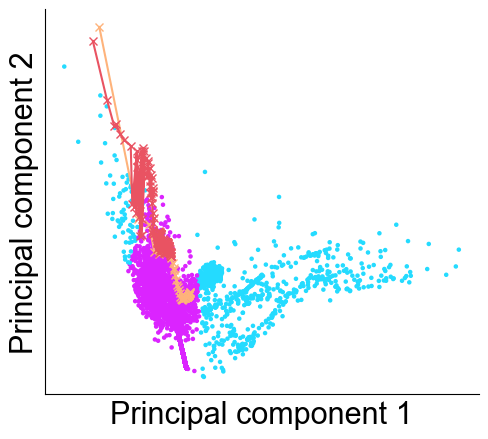

In [600]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5.6,5))
plt.scatter(train_tsne[:,0], train_tsne[:,1], s=5, c=rewards_action[0]<rewards_action[1]
, cmap='cool', vmin=-0.2, vmax=1.2)

plt.plot(const_pca[:,0], const_pca[:,1], color='#FEB37B', marker='x')
plt.plot(our_model_pca[:, 0], our_model_pca[:, 1], color='#E95362', marker='x')
# plt.colorbar()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# remove ticks
plt.xticks([])
plt.yticks([])
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\pca_contrast.png', dpi=300, transparent=True)

In [533]:
sum((rewards_action[0]-rewards_action[1])<0)

5654

In [545]:
device = 'cpu'
target=0.5
from torch import optim
import torch.nn as nn
from environment_realworld import DMFCENV
net = model
env = DMFCENV()


x = torch.tensor(X[1], dtype=torch.float32).unsqueeze(0).to(device)
x = x.repeat(64, 1, 1).to(device)
target = torch.tensor([target], dtype=torch.float32)

# Random initialization for searching
input_a = nn.Parameter(torch.randn((64, 4), dtype=torch.float32), requires_grad=True)

low = torch.tensor(env.action_space.low, dtype=torch.float32).to(device)
high = torch.tensor(env.action_space.high, dtype=torch.float32).to(device)

# optimize batch of input_a
optimizer = optim.AdamW([input_a], lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
net = net.to(device)
net.eval()
for epoch in tqdm(range(50)):
    optimizer.zero_grad()
    output = net(x, input_a.to(device))
    loss = torch.nn.MSELoss()(output, target)
    loss.backward()
    optimizer.step()
    scheduler.step()
    input_a.data = torch.clamp(input_a.data, low, high)

# 최종 결과 확인
with torch.no_grad():
    predicted_output = net(x.float(), input_a.float().to(device))
margin = torch.abs(predicted_output - target)
action = input_a[margin.argmin()]
print(action)
print("Predicted output", predicted_output[margin.argmin()])

C:\Users\EEL\miniconda3\envs\MOR2\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\EEL\AppData\Local\Temp\ipykernel_11008\1747207957.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X[1], dtype=torch.float32).unsqueeze(0).to(device)
  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\EEL\miniconda3\envs\MOR2\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 50/50 [00:05<00:00,  8.89it/s]

tensor([0.4000, 0.6500, 0.3100, 1.5356], grad_fn=<SelectBackward0>)
Predicted output tensor([0.1383])


In [557]:
 float(np.log10(50))

1.6989700043360187

In [556]:
print(input_a[margin.argmin()])
print(net(x[0:1], torch.tensor([[0.65000, 0.6500, 0.3100, float(np.log10(300))]])))
print(net(x[0:1], torch.tensor([[0.4000, 0.6500, 0.3100, float(np.log10(50))]])))

tensor([0.4000, 0.6500, 0.3100, 1.5356], grad_fn=<SelectBackward0>)
tensor([[0.1329]], grad_fn=<AddmmBackward0>)
tensor([[0.1378]], grad_fn=<AddmmBackward0>)


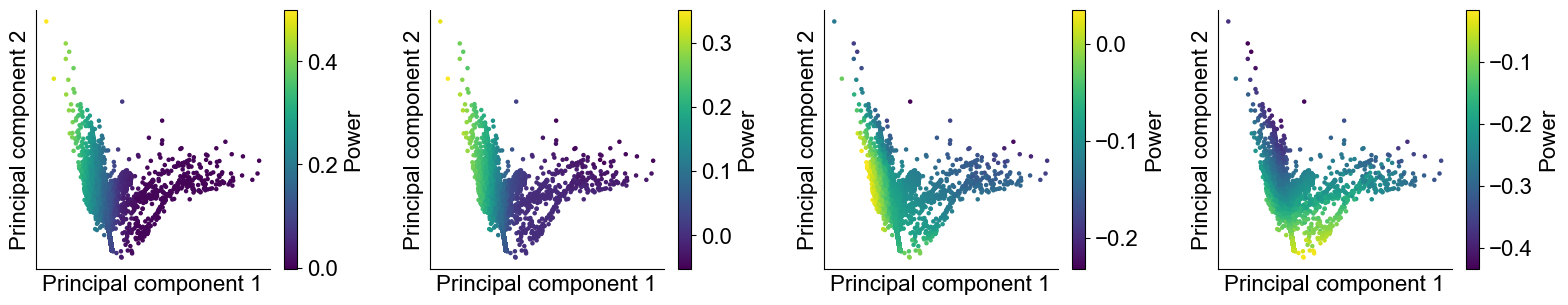

In [446]:
action_seeds = []
# action_seed = torch.tensor([0.4, 0.65, 1.0, 2.5]).to('cuda')
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(300))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(30))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(7))]))#.to('cuda'))
action_seeds.append(torch.tensor([0.02, 0.65, 0.31, float(np.log10(3))]))#.to('cuda'))

# plot the training and validation data points
train_embs = []
train_pred = []
val_embs = []
val_pred = []
test_embs = []
test_pred = []
model.eval()    # Set model to evaluate mode

for batch in train_loader:
    X, action, Y = batch
    # X = X.to('cuda')
    # Y = Y.to('cuda')
    emb = model.cnn(X)
    train_embs.append(emb.squeeze().cpu().detach().numpy())
train_embs = np.concatenate(train_embs)

# # PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_tsne = pca.fit_transform(train_embs)
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42)
# train_tsne = tsne.fit_transform(train_embs)

# font arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 4, figsize=(24/1.5,5/1.5))
for i, action_seed in enumerate(action_seeds):
    # plot the training and validation data points
    train_pred = []
    model.eval()    # Set model to evaluate mode

    for batch in train_loader:
        X, action, Y = batch
        # X = X.to('cuda')
        action = action_seed.repeat(len(X), 1)#.to('cuda')
        # Y = Y.to('cuda')
        emb = model.cnn(X)
        output = model(X, action)
        train_pred.append(output.squeeze().cpu().detach().numpy())
    train_pred = np.concatenate(train_pred)

    pcm = ax[i].scatter(train_tsne[:,0], train_tsne[:,1], s=5, c=train_pred, cmap='viridis')#, vmin=0.0)
    # colorbar label
    fig.colorbar(pcm, ax=ax[i], label='Power')
    ax[i].set_xlabel('Principal component 1')
    ax[i].set_ylabel('Principal component 2')
    # remove ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # remove top and right spines
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\pca.png', dpi=300, transparent=True)

In [442]:
train_tsne.shape

(6863, 2)

In [435]:
10**0.5, 10**0.85, 10**1.5, 10**2.5
np.log10(3)

0.47712125471966244

# 200 h

In [342]:
ref_potential = -0.9
ours_200h = pd.read_json('D:\\hongbin\\20240427_DMFC_long\\real_database.json')

In [343]:
calc_time(ours_200h)

In [344]:
ours_200h['order'][ours_200h['reward']>25]

713     {'step_id': 'exp36_17', 'step_actual_time': (3...
1520    {'step_id': 'exp79_4', 'step_actual_time': (30...
1586    {'step_id': 'exp82_11', 'step_actual_time': (3...
1864    {'step_id': 'exp96_16', 'step_actual_time': (3...
Name: order, dtype: object

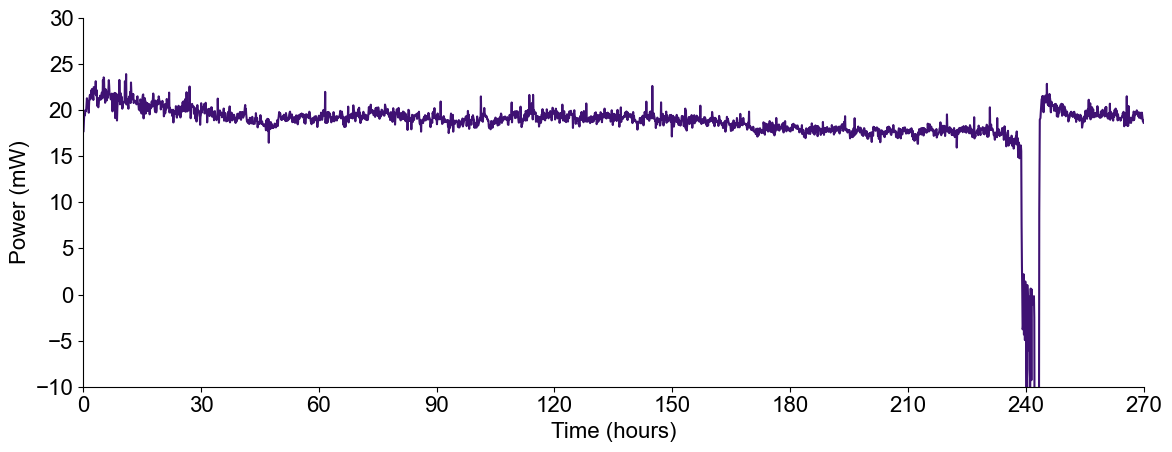

In [356]:
plt.rc('font', family='Arial', size=16)

fig, ax = plt.subplots(figsize=(12,4.8))
ax.plot((ours_200h['time'][ours_200h['reward']<25])/3600, ours_200h['reward'][ours_200h['reward']<25], label='AFC', color='#3F1173')
#3F1173, #952B80,
# ax.legend(fontsize=12, ncol=2)
# ax.legend(fontsize=12, bbox_to_anchor=(1,1))
# ax.get_legend().get_frame().set_linewidth(0.0)

plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Power (mW)', fontsize=16)
# plt.title('', fontsize=16)
# remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(-10, 30)
plt.xlim(0, 270)
plt.xticks([0, 30,60,90,120,150,180,210,240,270])
plt.tight_layout()
plt.savefig('C:\\Users\\EEL\\PycharmProjects\\MOR_RL\\Figure\\200h.png', dpi=300, transparent=True)